In [1]:
data_in = './data_in'
data_out = './data_out'
data_prefix = 'bois_doug_wash'

In [2]:
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']

In [3]:
import pandas as pd
import numpy as np
from glob import glob
import re
import nltk
from numpy.linalg import norm
from scipy.spatial.distance import pdist
import seaborn as sns
sns.set(style='ticks')
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

from scipy.linalg import norm, eigh
from sklearn.decomposition import PCA
import plotly_express as px

In [4]:
from nltk.corpus import stopwords

In [5]:
# collection of nltk stopwords
words = []
for x in stopwords.words('english'):
    words.append(x)

In [7]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('tagsets')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kaleb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kaleb\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kaleb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\kaleb\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


True

# Producing The VOCAB, LIB, TOKEN, BOW tables

In [6]:
roman = '[IVXLCM]+'
caps = "[A-Z';, -]+"
chap_pats = {
    23: {
        'start_line': 515,
        'end_line': 3736,
        'chapter': re.compile('^\s*CHAPTER\s+{}\s*$'.format(roman))
    },
    202: {
        'start_line': 788,
        'end_line': 12240,
        'chapter': re.compile("^\s*CHAPTER\s+{}.\s*".format(roman))
    },
    408: {
        'start_line': 55,
        'end_line': 6740,
        'chapter': re.compile("^\s*{}.\s*$".format(roman))
    },
    59116: {\
        'start_line': 90,
        'end_line': 1597,
        'chapter': re.compile("^\s*{}.\s*$".format(roman))
    },
    62799: {
        'start_line': 360,
        'end_line': 9147,
        'chapter': re.compile('^\s*CHAPTER\s+{}\s*$'.format(roman))
    },
    64504: {
        'start_line': 333,
        'end_line': 6380,
        'chapter': re.compile('^\s*CHAPTER\s+{}\s*$'.format(roman))
    },
    2376: {
        'start_line': 338,
        'end_line': 7075,
        'chapter': re.compile('^\s*Chapter\s+{}.\s*'.format(roman))
    },
    15210: {
        'start_line': 187,
        'end_line': 7455,
        'chapter': re.compile("^\s*{}\s*$".format(roman))
    },
    15359: {
        'start_line': 130,
        'end_line': 5683,
        'chapter': re.compile("^\s*{}\s+[A-Z]+".format(roman))
    },
    26507: {
        'start_line': 180,
        'end_line': 3794,
        'chapter': re.compile("^\s*CHAPTER\s+{}.\s*$".format(roman))
    },
    31839: {
        'start_line': 110,
        'end_line': 970,
        'chapter': re.compile('ADDRESS.')
    },
    35399: {
        'start_line': 165,
        'end_line': 3023,
        'chapter': re.compile("^\s*CHAPTER\s+{}\s*$".format(roman))
    },
    45125: {
        'start_line': 205,
        'end_line': 890,
        'chapter': re.compile("^\s*{}\s*$".format(roman))
    }
}

In [8]:
def acquire_epubs(epub_list, chap_pats, OHCO=OHCO):
    
    my_lib = []
    my_doc = []

    for epub_file in epub_list:
        
        # Get PG ID from filename
        book_id = int(epub_file.split('in')[1].split('.')[0].replace('pg', '').split('-')[0][1:])
        print("BOOK ID", book_id)
        
        # Import file as lines
        lines = open(epub_file, 'r', encoding='utf-8-sig').readlines()
        df = pd.DataFrame(lines, columns=['line_str'])
        df.index.name = 'line_num'
        df.line_str = df.line_str.str.strip()
        df['book_id'] = book_id
        
        # FIX CHARACTERS TO IMPROVE TOKENIZATION
        df.line_str = df.line_str.str.replace('—', ' — ')
        df.line_str = df.line_str.str.replace('-', ' - ')
        
        # Get book title and put into LIB table -- note problems, though
        book_title = re.sub(r"The Project Gutenberg eBook( of|,) ", "", df.loc[0].line_str, flags=re.IGNORECASE)
        book_title = re.sub(r"Project Gutenberg's ", "", book_title, flags=re.IGNORECASE)
        
        # Remove cruft
        a = chap_pats[book_id]['start_line'] - 1
        b = chap_pats[book_id]['end_line'] + 1
        df = df.iloc[a:b]
        
        # Chunk by chapter
        chap_lines = df.line_str.str.match(chap_pats[book_id]['chapter'])
        chap_nums = [i+1 for i in range(df.loc[chap_lines].shape[0])]
        df.loc[chap_lines, 'chap_num'] = chap_nums
        df.chap_num = df.chap_num.ffill()

        # Clean up
#         df = df[~df.chap_num.isna()] 
        df = df.dropna(subset=['chap_num']) # Remove everything before Chapter 1
        df = df.loc[~chap_lines] # Remove chapter heading lines
        df['chap_num'] = df['chap_num'].astype('int')
        
        # Group -- Note that we exclude the book level in the OHCO at this point
        df = df.groupby(OHCO[1:2]).line_str.apply(lambda x: '\n'.join(x)).to_frame() # Make big string
        
        # Split into paragrpahs
        df = df['line_str'].str.split(r'\n\n+', expand=True).stack().to_frame().rename(columns={0:'para_str'})
        df.index.names = OHCO[1:3] # MAY NOT BE NECESSARY UNTIL THE END
        df['para_str'] = df['para_str'].str.replace(r'\n', ' ').str.strip()
        df = df[~df['para_str'].str.match(r'^\s*$')] # Remove empty paragraphs
        
        # Set index
        df['book_id'] = book_id
        df = df.reset_index().set_index(OHCO[:3])

        # Register
        my_lib.append((book_id, book_title, epub_file))
        my_doc.append(df)

    docs = pd.concat(my_doc)
    library = pd.DataFrame(my_lib, columns=['book_id', 'book_title', 'book_file']).set_index('book_id')
    return library, docs

In [9]:
epubs = [epub for epub in sorted(glob('{}/*.txt'.format(data_in)))]

In [33]:
LIB, DOC = acquire_epubs(epubs, chap_pats)

BOOK ID 202
BOOK ID 23
BOOK ID 408
BOOK ID 59116
BOOK ID 62799
BOOK ID 64504
BOOK ID 15210
BOOK ID 15359
BOOK ID 2376
BOOK ID 26507
BOOK ID 31839
BOOK ID 35399
BOOK ID 45125


In [102]:
DOC

book_id  chap_num  para_num  \
0         202         1         0   
1         202         1         1   
2         202         1         2   
3         202         1         3   
4         202         1         4   
...       ...       ...       ...   
5940    45125         4        30   
5941    45125         4        31   
5942    45125         4        32   
5943    45125         4        33   
5944    45125         4        34   

                                               para_str  
0     PLACE OF BIRTH -  - CHARACTER OF THE DISTRICT ...  
1     In Talbot county, Eastern Shore, Maryland, nea...  
2     The name of this singularly unpromising and tr...  
3     It was in this dull, flat, and unthrifty distr...  
4     The reader will pardon so much about the place...  
...                                                 ...  
5940                                      Refrain: -  -  
5941  Turn out here and shuck dis corn; Oh! Oh! Oh! ...  
5942  Half the charm of Southern life was made by th...  
5943  The native quality of the Negro, his natural s...  
5944  Almost all that has been said of slavery, whet...  

[5945 rows x 4 columns]

In [10]:
def tokenize(doc_df, OHCO=OHCO, remove_pos_tuple=False, ws=False):
    
    # Paragraphs to Sentences
    df = doc_df.para_str\
        .apply(lambda x: pd.Series(nltk.sent_tokenize(x)))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'sent_str'})
    
    # Sentences to Tokens
    # Local function to pick tokenizer
    def word_tokenize(x):
        if ws:
            s = pd.Series(nltk.pos_tag(nltk.WhitespaceTokenizer().tokenize(x)))
        else:
            s = pd.Series(nltk.pos_tag(nltk.word_tokenize(x)))
        return s
            
    df = df.sent_str\
        .apply(word_tokenize)\
        .stack()\
        .to_frame()\
        .rename(columns={0:'pos_tuple'})
    
    # Grab info from tuple
    df['pos'] = df.pos_tuple.apply(lambda x: x[1])
    df['token_str'] = df.pos_tuple.apply(lambda x: x[0])
    if remove_pos_tuple:
        df = df.drop('pos_tuple', 1)
    
    # Add index
    df.index.names = OHCO
    
    return df

## Token Table

In [36]:
TOKEN = tokenize(DOC, ws=True)

In [38]:
TOKEN['term_str'] = TOKEN['token_str'].str.lower().str.replace('[\W_]', '')

In [39]:
TOKEN

pos_tuple  pos token_str  \
book_id chap_num para_num sent_num token_num                                  
202     1        0        0        0             (PLACE, NN)   NN     PLACE   
                                   1               (OF, NNP)  NNP        OF   
                                   2            (BIRTH, NNP)  NNP     BIRTH   
                                   3                  (-, :)    :         -   
                                   4                  (-, :)    :         -   
...                                                      ...  ...       ...   
45125   4        34       1        25         (brighter, NN)   NN  brighter   
                                   26              (and, CC)   CC       and   
                                   27            (more, RBR)  RBR      more   
                                   28         (cheerful, JJ)   JJ  cheerful   
                                   29            (view., NN)   NN     view.   

                                              term_str  
book_id chap_num para_num sent_num token_num            
202     1        0        0        0             place  
                                   1                of  
                                   2             birth  
                                   3                    
                                   4                    
...                                                ...  
45125   4        34       1        25         brighter  
                                   26              and  
                                   27             more  
                                   28         cheerful  
                                   29             view  

[693647 rows x 4 columns]

## Vocab Table

In [40]:
VOCAB = TOKEN.term_str.value_counts().to_frame().rename(columns={'index':'term_str', 'term_str':'n'})\
    .sort_index().reset_index().rename(columns={'index':'term_str'})
VOCAB.index.name = 'term_id'

In [41]:
VOCAB['num'] = VOCAB.term_str.str.match("\d+").astype('int')

In [42]:
VOCAB

term_str      n  num
term_id                      
0                  10909    0
1              01      1    1
2               1     34    1
3              10     19    1
4             100     11    1
...           ...    ...  ...
24209           à      1    0
24210    æschylus      2    0
24211        æsop      1    0
24212    æsthetic      1    0
24213       élite      1    0

[24214 rows x 3 columns]

In [43]:
# adding stopword tags on the vocab table
sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1

In [44]:
VOCAB['stop'] = VOCAB.term_str.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')

In [45]:
VOCAB[VOCAB.stop == 1].sample(10)

term_str     n  num  stop
term_id                          
15324       over   618    0     1
14710         no  1822    0     1
10659    himself   420    0     1
12085        its  1328    0     1
10552       here   658    0     1
24108          y    13    0     1
21467      their  2519    0     1
21508      these  1360    0     1
21468     theirs    20    0     1
18522          s    35    0     1

In [46]:
# Adding word stems to the vocab table
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()
VOCAB['p_stem'] = VOCAB.term_str.apply(stemmer.stem)

In [47]:
VOCAB.sample(10)

term_str   n  num  stop        p_stem
term_id                                            
13529          marquis   2    0     0        marqui
21949           tramps   1    0     0         tramp
16133           pining   1    0     0          pine
2439          barriers  19    0     0       barrier
2178       auxiliaries   2    0     0     auxiliari
20647           stuffs   3    0     0         stuff
16405              pop   1    0     0           pop
24065           wright  10    0     0        wright
5759     daguerreotype   1    0     0  daguerreotyp
6428          devotees   2    0     0        devote

## Lib Table

In [48]:
# extracting name of authors from the text and adding it to the LIB table
LIB_author_title = []
for x in LIB['book_title']:
    LIB_author_title.append(x.split('by'))

LIB_author_title = pd.DataFrame(LIB_author_title)
LIB_author_title.columns = ['title', 'Author']
LIB_author_title.index = LIB.index
LIB = pd.concat([LIB, LIB_author_title], axis = 1)

### Saving the initial versions of the DOC, LIB, VOCAB and TOKEN tables

In [49]:
# saving all the tables to the output directory
DOC.to_csv('{}/{}-DOC.csv'.format(data_out, data_prefix))
LIB.to_csv('{}/{}-LIB.csv'.format(data_out, data_prefix))
VOCAB.to_csv('{}/{}-VOCAB.csv'.format(data_out, data_prefix))
TOKEN.to_csv('{}/{}-TOKEN.csv'.format(data_out, data_prefix))

# Computing TFIDF scores 

In [11]:
# reading the tables produced on the preveous sections.
DOC = pd.read_csv('{}/{}-DOC.csv'.format(data_out, data_prefix))
LIB = pd.read_csv('{}/{}-LIB.csv'.format(data_out, data_prefix)).set_index('book_id')
VOCAB = pd.read_csv('{}/{}-VOCAB.csv'.format(data_out, data_prefix)).set_index('term_str')
TOKEN = pd.read_csv('{}/{}-TOKEN.csv'.format(data_out, data_prefix))

In [12]:
#there are two na entries. so, remove them
VOCAB = VOCAB[~VOCAB.index.isna()]

In [13]:
DOC.head()

book_id  chap_num  para_num  \
0      202         1         0   
1      202         1         1   
2      202         1         2   
3      202         1         3   
4      202         1         4   

                                            para_str  
0  PLACE OF BIRTH -  - CHARACTER OF THE DISTRICT ...  
1  In Talbot county, Eastern Shore, Maryland, nea...  
2  The name of this singularly unpromising and tr...  
3  It was in this dull, flat, and unthrifty distr...  
4  The reader will pardon so much about the place...

In [14]:
LIB.head()

book_title  \
book_id                                                      
202      Project Gutenberg’s My Bondage and My Freedom,...   
23       Narrative of the Life of Frederick Douglass, b...   
408           The Souls of Black Folk, by W. E. B. Du Bois   
59116     Why is the Negro Lynched?, by Frederick Douglass   
62799               John Brown, by W. E. Burghardt Du Bois   

                     book_file  \
book_id                          
202        ./data_in\202-0.txt   
23          ./data_in\23-0.txt   
408        ./data_in\408-0.txt   
59116    ./data_in\59116-0.txt   
62799    ./data_in\62799-0.txt   

                                                   title  \
book_id                                                    
202      Project Gutenberg’s My Bondage and My Freedom,    
23         Narrative of the Life of Frederick Douglass,    
408                            The Souls of Black Folk,    
59116                        Why is the Negro Lynched?,    
62799                                       John Brown,    

                           Author  
book_id                            
202            Frederick Douglass  
23             Frederick Douglass  
408              W. E. B. Du Bois  
59116          Frederick Douglass  
62799     W. E. Burghardt Du Bois

In [15]:
VOCAB.head()

term_id   n  num  stop p_stem
term_str                               
01              1   1    1     0     01
1               2  34    1     0      1
10              3  19    1     0     10
100             4  11    1     0    100
1000            5   8    1     0   1000

In [16]:
TOKEN.head()

book_id  chap_num  para_num  sent_num  token_num         pos_tuple  pos  \
0      202         1         0         0          0   ('PLACE', 'NN')   NN   
1      202         1         0         0          1     ('OF', 'NNP')  NNP   
2      202         1         0         0          2  ('BIRTH', 'NNP')  NNP   
3      202         1         0         0          3        ('-', ':')    :   
4      202         1         0         0          4        ('-', ':')    :   

  token_str term_str  
0     PLACE    place  
1        OF       of  
2     BIRTH    birth  
3         -      NaN  
4         -      NaN

In [17]:
def kaleb_TFIDF(token, vocab, ohco, tftype):
    bow = token.groupby(ohco+['term_str']).term_str.count().to_frame('tf_n')
    D = bow.groupby(ohco).tf_n
    if tftype == 'tf_cp':
        bow['tf_cp'] = D.apply(lambda x: x / x.sum())
    elif tftype == 'tf_bool':
        bow['tf_bool'] = 1
    elif tftype == 'tf_l2':
    # bow['tf_jp'] = D.apply(lambda x: x / x.sum().sum()) # jp = P(w,d) 
        bow['tf_l2'] = D.apply(lambda x: x / np.sqrt((x**2).sum()))
    elif tftype == 'tf_logn':
        bow['tf_logn'] = D.apply(lambda x: np.log2(1 + x))
    elif tftype == 'tf_sub':
        bow['tf_sub'] = D.apply(lambda x: 1 + np.log2(x))
    elif tftype == 'tf_max4':
        bow['tf_max4'] = D.apply(lambda x: .4 + .6 * (x / x.max()))
    elif tftype == 'tf_max5':
        bow['tf_max5'] = D.apply(lambda x: .5 + .5 * (x / x.max()))
    elif tftype == 'tf_max9':
        bow['tf_max9'] = D.apply(lambda x: .9 + .1 * (x / x.max()))
    elif tftype == 'tf_bool2':
        bow['tf_bool2'] = D.apply(lambda x: 1 / len(x))
    else:
        print(" ")

    # df computation
    vocab['df'] = bow.groupby('term_str').tf_n.count()
#     print(vocab.head())
    # idf computation
    N_docs = len(D.groups)
#     print(N_docs)
    vocab['idf'] = np.log2(N_docs/(vocab.df))
    vocab['dfidf'] = vocab.df*vocab.idf
#     print(vocab.head())
    
#     bow['dfidf']
    
    
#     for tf_type in bow.columns:
    bow[f'tfidf_{tftype[2:]}'] = bow[tftype]*vocab.idf
    
    tfidf_sum_cols = []
#     for tf_type in bow.columns[:10]:
    bow_col = f"tfidf_{tftype[2:]}"
    vocab_col = f"tfidf{tftype[2:]}_sum"
    tfidf_sum_cols.append(vocab_col)
    vocab[vocab_col] = bow.groupby('term_str')[bow_col].sum()
#         vocab[vocab_col] = normalize(vocab[vocab_col], N_docs)
#     print(vocab.head())
    
    return bow, vocab

# TFIDF

In [18]:
def bow_tf_calculator(token, ohco, tftype):
    bow = token.groupby(ohco+['term_str']).term_str.count().to_frame('tf_n')
    D = bow.groupby(ohco).tf_n
    if tftype == 'tf_cp':
        bow['tf_cp'] = D.apply(lambda x: x / x.sum())
    elif tftype == 'tf_bool':
        bow['tf_bool'] = 1
    elif tftype == 'tf_l2':
    # bow['tf_jp'] = D.apply(lambda x: x / x.sum().sum()) # jp = P(w,d) 
        bow['tf_l2'] = D.apply(lambda x: x / np.sqrt((x**2).sum()))
    elif tftype == 'tf_logn':
        bow['tf_logn'] = D.apply(lambda x: np.log2(1 + x))
    elif tftype == 'tf_sub':
        bow['tf_sub'] = D.apply(lambda x: 1 + np.log2(x))
    elif tftype == 'tf_max4':
        bow['tf_max4'] = D.apply(lambda x: .4 + .6 * (x / x.max()))
    elif tftype == 'tf_max5':
        bow['tf_max5'] = D.apply(lambda x: .5 + .5 * (x / x.max()))
    elif tftype == 'tf_max9':
        bow['tf_max9'] = D.apply(lambda x: .9 + .1 * (x / x.max()))
    elif tftype == 'tf_bool2':
        bow['tf_bool2'] = D.apply(lambda x: 1 / len(x))
    else:
        print(" ")
    
    return D, bow
  

In [19]:
def vocab_df_calculator(vocab, bow, D):
    vocab['df'] = bow.groupby('term_str').tf_n.count()
    # idf computation
    N_docs = len(D.groups)
    vocab['idf'] = np.log2(N_docs/(vocab.df))
    vocab['dfidf'] = vocab.df*vocab.idf
    
    return vocab
    

In [20]:
bow, vocab  = kaleb_TFIDF(TOKEN, VOCAB, OHCO[:2], 'tf_max4')

In [21]:
vocab.sort_values('dfidf', ascending=False).head(10)

term_id    n  num  stop    p_stem  df       idf      dfidf  \
term_str                                                                
support      20910   88    0     0   support  53  1.451989  76.955398   
bad           2287   97    0     0       bad  53  1.451989  76.955398   
proper       16918   97    0     0    proper  53  1.451989  76.955398   
account        902   88    0     0   account  53  1.451989  76.955398   
direction     6564   97    0     0    direct  53  1.451989  76.955398   
cost          5298  142    0     0      cost  53  1.451989  76.955398   
prejudice    16619  113    0     0  prejudic  53  1.451989  76.955398   
generally     9562   94    0     0     gener  53  1.451989  76.955398   
faith         8418   90    0     0     faith  53  1.451989  76.955398   
son          19937  128    0     0       son  53  1.451989  76.955398   

           tfidf_max4_sum  
term_str                   
support         31.015634  
bad             31.083324  
proper          31.053571  
account         31.023138  
direction       31.054038  
cost            31.178317  
prejudice       31.038436  
generally       31.099252  
faith           31.007984  
son             31.186631

In [22]:
vocab.sort_values('tfidf_max4_sum', ascending=False).head(10)

term_id    n  num  stop   p_stem  df       idf      dfidf  \
term_str                                                                
students      20637  382    0     0  student  48  1.594947  76.557436   
africa         1167  458    0     0   africa  52  1.479469  76.932407   
john          12191  603    0     0     john  53  1.451989  76.955398   
brown          3353  745    0     0    brown  43  1.753644  75.406706   
tuskegee      22229  394    0     0  tuskege  44  1.720477  75.701009   
plantation    16216  248    0     0  plantat  57  1.347019  76.780087   
coloured       4569  287    0     0   colour  44  1.720477  75.701009   
crime          5518  203    0     0    crime  54  1.425022  76.951166   
labor         12502  243    0     0    labor  52  1.479469  76.932407   
cotton         5313  199    0     0   cotton  51  1.507484  76.881671   

            tfidf_max4_sum  
term_str                    
students         32.093030  
africa           32.050532  
john             32.011575  
brown            31.819626  
tuskegee         31.817586  
plantation       31.626531  
coloured         31.378721  
crime            31.330155  
labor            31.305290  
cotton           31.281156

In [23]:
bow

tf_n   tf_max4  tfidf__max4
book_id chap_num term_str                             
23      1        1835         1  0.406122     1.628545
                 a           50  0.706122     0.000000
                 about        7  0.442857     0.017873
                 absent       1  0.406122     1.078802
                 accurate     1  0.406122     1.866111
...                         ...       ...          ...
64504   19       yet          1  0.401935     0.165487
                 york         4  0.407742     0.638197
                 you          1  0.401935     0.209689
                 your         3  0.405806     0.443322
                 youth        1  0.401935     0.746788

[184024 rows x 3 columns]

In [24]:
LIB.head()

book_title  \
book_id                                                      
202      Project Gutenberg’s My Bondage and My Freedom,...   
23       Narrative of the Life of Frederick Douglass, b...   
408           The Souls of Black Folk, by W. E. B. Du Bois   
59116     Why is the Negro Lynched?, by Frederick Douglass   
62799               John Brown, by W. E. Burghardt Du Bois   

                     book_file  \
book_id                          
202        ./data_in\202-0.txt   
23          ./data_in\23-0.txt   
408        ./data_in\408-0.txt   
59116    ./data_in\59116-0.txt   
62799    ./data_in\62799-0.txt   

                                                   title  \
book_id                                                    
202      Project Gutenberg’s My Bondage and My Freedom,    
23         Narrative of the Life of Frederick Douglass,    
408                            The Souls of Black Folk,    
59116                        Why is the Negro Lynched?,    
62799                                       John Brown,    

                           Author  
book_id                            
202            Frederick Douglass  
23             Frederick Douglass  
408              W. E. B. Du Bois  
59116          Frederick Douglass  
62799     W. E. Burghardt Du Bois

### Calculating TFIDF without subseting the copus based on authors. 

In [25]:
TFIDF = bow.tfidf__max4.unstack(fill_value=0)

In [26]:
TFIDF = TFIDF.groupby(OHCO[0]).mean()

In [27]:
TFIDF

term_str        01         1        10       100      1000     10000  \
book_id                                                                
23        0.000000  0.104174  0.000000  0.000000  0.000000  0.000000   
202       0.000000  0.045794  0.054039  0.000000  0.000000  0.000000   
408       0.000000  0.164515  0.000000  0.125378  0.000000  0.000000   
2376      0.000000  0.067441  0.079695  0.000000  0.000000  0.000000   
15210     0.000000  0.114742  0.407509  0.000000  0.000000  0.224496   
15359     0.000000  0.479628  0.225494  0.440926  0.461317  0.000000   
26507     0.000000  0.143910  0.000000  0.000000  0.000000  0.000000   
31839     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
35399     0.000000  0.573336  0.338067  0.000000  0.460340  0.000000   
45125     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
59116     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
62799     0.000000  0.176289  0.208556  0.404686  0.284410  0.345792   
64504     0.151887  0.243869  0.286193  0.000000  0.000000  0.000000   

term_str    100000   1000000  10000000  100000000  ...      zulu  zululand  \
book_id                                            ...                       
23        0.000000  0.000000  0.000000   0.000000  ...  0.000000  0.000000   
202       0.000000  0.000000  0.000000   0.000000  ...  0.000000  0.000000   
408       0.000000  0.000000  0.000000   0.000000  ...  0.000000  0.000000   
2376      0.000000  0.169428  0.000000   0.000000  ...  0.000000  0.000000   
15210     0.000000  0.000000  0.000000   0.000000  ...  0.000000  0.000000   
15359     0.347173  0.000000  0.162584   0.206825  ...  0.419175  0.207172   
26507     0.000000  0.000000  0.000000   0.000000  ...  0.000000  0.309897   
31839     0.000000  0.000000  0.000000   0.000000  ...  0.000000  0.000000   
35399     0.519238  0.000000  0.000000   0.000000  ...  0.000000  0.000000   
45125     0.000000  0.000000  0.492738   0.000000  ...  0.000000  0.000000   
59116     0.000000  0.000000  0.000000   0.000000  ...  0.000000  0.000000   
62799     0.159706  0.000000  0.299894   0.190705  ...  0.000000  0.000000   
64504     0.000000  0.000000  0.102768   0.000000  ...  0.000000  0.000000   

term_str     zulus     zunis  zymbabwe         à  æschylus      æsop  \
book_id                                                                
23        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
202       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
408       0.000000  0.000000  0.000000  0.000000  0.177410  0.000000   
2376      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
15210     0.224496  0.000000  0.207862  0.288055  0.000000  0.000000   
15359     0.379722  0.240126  0.522002  0.000000  0.206821  0.239771   
26507     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
31839     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
35399     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
45125     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
59116     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
62799     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
64504     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

term_str  æsthetic     élite  
book_id                       
23        0.000000  0.000000  
202       0.000000  0.000000  
408       0.000000  0.000000  
2376      0.000000  0.000000  
15210     0.000000  0.000000  
15359     0.000000  0.000000  
26507     0.360206  0.000000  
31839     0.000000  0.000000  
35399     0.000000  0.000000  
45125     0.000000  0.000000  
59116     0.000000  0.414525  
62799     0.000000  0.000000  
64504     0.000000  0.000000  

[13 rows x 24212 columns]

In [28]:
sum_method = 'tfidf_max4_sum'
top_4000 = vocab.sort_values(sum_method, ascending=False)[:4000]

In [29]:
# sum_method = 'dfidf'
top_10 = vocab.sort_values(sum_method, ascending=False)[:10]

In [30]:
TFIDF[top_4000.index]

term_str  students    africa      john     brown  tuskegee  plantation  \
book_id                                                                  
23        0.000000  0.109129  0.107173  0.000000  0.000000    0.464182   
202       0.000000  0.142902  0.164432  0.056677  0.000000    0.358422   
408       0.138352  0.212788  0.257292  0.507490  0.099284    0.156092   
2376      0.594929  0.105081  0.312089  0.041382  0.638559    0.354371   
15210     0.064003  0.371337  0.116631  0.640749  0.207607    0.054217   
15359     0.160160  0.650855  0.340680  0.353158  0.000000    0.090447   
26507     0.247208  0.226603  0.073113  0.000000  0.442248    0.136517   
31839     0.000000  0.593253  0.628237  0.783063  0.000000    0.000000   
35399     0.482428  0.449491  0.146535  0.000000  0.000000    0.270603   
45125     0.000000  0.328968  0.147273  0.000000  0.000000    0.433659   
59116     0.000000  0.089270  0.088979  0.000000  0.000000    0.000000   
62799     0.148154  0.187763  0.644397  0.804017  0.000000    0.083125   
64504     0.612999  0.126463  0.061653  0.037563  0.734635    0.143845   

term_str  coloured     crime     labor    cotton  ...  influenced     hosts  \
book_id                                           ...                         
23        0.000000  0.158344  0.108678  0.000000  ...    0.000000  0.000000   
202       0.000000  0.275948  0.239999  0.072631  ...    0.123868  0.000000   
408       0.000000  0.288765  0.214908  0.265525  ...    0.110753  0.332214   
2376      0.717441  0.067451  0.000000  0.179247  ...    0.091174  0.000000   
15210     0.000000  0.459366  0.480217  0.303521  ...    0.000000  0.310332   
15359     0.000000  0.047852  0.250920  0.202830  ...    0.129157  0.387403   
26507     0.625152  0.293743  0.149152  0.303467  ...    0.000000  0.000000   
31839     0.000000  0.574241  0.000000  0.000000  ...    0.000000  1.547012   
35399     0.000000  0.433780  0.620126  0.611449  ...    0.774081  0.000000   
45125     0.000000  0.000000  0.616287  0.307372  ...    0.000000  0.000000   
59116     0.619118  0.439764  0.000000  0.000000  ...    0.000000  0.000000   
62799     0.000000  0.264365  0.458230  0.279251  ...    0.119139  0.119109   
64504     0.518273  0.060947  0.062741  0.394652  ...    0.163497  0.000000   

term_str  convictions   counter  bitterly  sufferings  conquering  confused  \
book_id                                                                       
23           0.000000  0.000000  0.000000    0.140625    0.000000  0.000000   
202          0.123845  0.124110  0.062215    0.372222    0.000000  0.124083   
408          0.110484  0.221124  0.222004    0.000000    0.000000  0.331782   
2376         0.000000  0.000000  0.000000    0.000000    0.000000  0.000000   
15210        0.000000  0.154718  0.619294    0.309917    0.464795  0.000000   
15359        0.000000  0.129457  0.128790    0.000000    0.646067  0.000000   
26507        0.000000  0.000000  0.000000    0.000000    0.000000  0.000000   
31839        1.547012  0.000000  0.000000    0.000000    0.000000  0.000000   
35399        0.773235  0.000000  0.000000    0.000000    0.387354  0.000000   
45125        0.000000  0.000000  0.000000    0.000000    0.000000  0.000000   
59116        0.222835  0.000000  0.000000    0.000000    0.000000  0.222283   
62799        0.358116  0.357176  0.238171    0.118949    0.119053  0.357177   
64504        0.000000  0.081876  0.000000    0.000000    0.000000  0.081660   

term_str   scarred    veiled  
book_id                       
23        0.140792  0.000000  
202       0.186035  0.000000  
408       0.221044  0.332305  
2376      0.091039  0.000000  
15210     0.465594  0.620227  
15359     0.000000  0.129118  
26507     0.000000  0.000000  
31839     0.000000  0.000000  
35399     0.000000  0.386508  
45125     0.000000  0.000000  
59116     0.000000  0.000000  
62799     0.000000  0.119023  
64504     0.000000  0.000000  

[13 rows x 4000 columns]

### The top 10 terms from all the copus based on max4 method are the following

### ['students', 'africa', 'john', 'brown', 'tuskegee', 'plantation', 'coloured', 'crime', 'labor', 'cotton']

In [31]:
list(top_10.index)

['students',
 'africa',
 'john',
 'brown',
 'tuskegee',
 'plantation',
 'coloured',
 'crime',
 'labor',
 'cotton']

In [32]:
DOC.head()

book_id  chap_num  para_num  \
0      202         1         0   
1      202         1         1   
2      202         1         2   
3      202         1         3   
4      202         1         4   

                                            para_str  
0  PLACE OF BIRTH -  - CHARACTER OF THE DISTRICT ...  
1  In Talbot county, Eastern Shore, Maryland, nea...  
2  The name of this singularly unpromising and tr...  
3  It was in this dull, flat, and unthrifty distr...  
4  The reader will pardon so much about the place...

In [33]:
LIB

book_title  \
book_id                                                      
202      Project Gutenberg’s My Bondage and My Freedom,...   
23       Narrative of the Life of Frederick Douglass, b...   
408           The Souls of Black Folk, by W. E. B. Du Bois   
59116     Why is the Negro Lynched?, by Frederick Douglass   
62799               John Brown, by W. E. Burghardt Du Bois   
64504                 Working with the Hands, by Booker T.   
15210                       Darkwater, by W. E. B. Du Bois   
15359                         The Negro, by W.E.B. Du Bois   
2376     Up From Slavery: An Autobiography, by Booker T...   
26507    The Future of the American Negro, by Booker T....   
31839                    John Brown, by Frederick Douglass   
35399    The Negro in the South, by Booker T. Washingto...   
45125        The Story of Slavery, by Booker T. Washington   

                     book_file  \
book_id                          
202        ./data_in\202-0.txt   
23          ./data_in\23-0.txt   
408        ./data_in\408-0.txt   
59116    ./data_in\59116-0.txt   
62799    ./data_in\62799-0.txt   
64504    ./data_in\64504-0.txt   
15210    ./data_in\pg15210.txt   
15359    ./data_in\pg15359.txt   
2376      ./data_in\pg2376.txt   
26507    ./data_in\pg26507.txt   
31839    ./data_in\pg31839.txt   
35399    ./data_in\pg35399.txt   
45125    ./data_in\pg45125.txt   

                                                   title  \
book_id                                                    
202      Project Gutenberg’s My Bondage and My Freedom,    
23         Narrative of the Life of Frederick Douglass,    
408                            The Souls of Black Folk,    
59116                        Why is the Negro Lynched?,    
62799                                       John Brown,    
64504                           Working with the Hands,    
15210                                        Darkwater,    
15359                                        The Negro,    
2376                 Up From Slavery: An Autobiography,    
26507                 The Future of the American Negro,    
31839                                       John Brown,    
35399                           The Negro in the South,    
45125                             The Story of Slavery,    

                                                   Author  
book_id                                                    
202                                    Frederick Douglass  
23                                     Frederick Douglass  
408                                      W. E. B. Du Bois  
59116                                  Frederick Douglass  
62799                             W. E. Burghardt Du Bois  
64504                                           Booker T.  
15210                                    W. E. B. Du Bois  
15359                                      W.E.B. Du Bois  
2376                                 Booker T. Washington  
26507                                Booker T. Washington  
31839                                  Frederick Douglass  
35399     Booker T. Washington and W. E. Burghardt DuBois  
45125                                Booker T. Washington

### TFIDF score for each author

In [256]:
Author_bookid = {'Frederick Douglass': [202, 23, 59116, 31839], 
                'W.E.B.D. Bois': [408, 62799, 15210, 15359, 35399],
                'Booker T. Washington': [64504, 2376, 26507, 45125, 35399]}

In [35]:
Fredrick_Token = TOKEN[TOKEN.book_id.isin(Author_bookid['Frederick Douglass'])]
Booker_Token = TOKEN[TOKEN.book_id.isin(Author_bookid['Booker T. Washington'])]
Bois_Token = TOKEN[TOKEN.book_id.isin(Author_bookid['W.E.B.D. Bois'])]

In [36]:
DD, bowbow = bow_tf_calculator(Fredrick_Token, OHCO[:2], 'tf_max4')
bookD, bookbow = bow_tf_calculator(Booker_Token, OHCO[:2], 'tf_max4')


In [37]:
Dvocab = vocab_df_calculator(VOCAB, bowbow, DD)
bookvocab = vocab_df_calculator(VOCAB, bookbow, bookD)

In [38]:
Fredrick_Token.book_id.value_counts()

202      132309
23        36925
59116     15511
31839     10026
Name: book_id, dtype: int64

In [39]:
VOCAB_cp_1 = VOCAB.copy()
VOCAB_cp_2 = VOCAB.copy()
VOCAB_cp_3 = VOCAB.copy()

In [40]:
fbow, fvocab  = kaleb_TFIDF(Fredrick_Token, VOCAB_cp_1, OHCO[:2], 'tf_max4')
bois_bow, bois_vocab  = kaleb_TFIDF(Bois_Token, VOCAB_cp_2, OHCO[:2], 'tf_max4')
booker_bow, booker_vocab  = kaleb_TFIDF(Booker_Token, VOCAB_cp_3, OHCO[:2], 'tf_max4')

### TFIDF Fredrick Douglass

In [41]:
fTFIDF = fbow.tfidf__max4.unstack(fill_value=0)
fTFIDF = fTFIDF.groupby(OHCO[0]).mean()
fTFIDF

term_str         1        10       103       105       108        11  \
book_id                                                                
23        0.162548  0.000000  0.000000  0.000000  0.000000  0.000000   
202       0.071455  0.087478  0.088075  0.088075  0.088075  0.087478   
31839     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
59116     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

term_str      11th        12       129       142  ...     yours  yourself  \
book_id                                           ...                       
23        0.199235  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
202       0.000000  0.087415  0.088095  0.088041  ...  0.087605  0.188527   
31839     0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
59116     0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   

term_str  yourselves     youth  youthful      zeal   zealous      zest  \
book_id                                                                  
23          0.163322  0.117414  0.116807  0.000000  0.000000  0.000000   
202         0.000000  0.151165  0.202272  0.000000  0.087736  0.087698   
31839       0.000000  1.258108  0.000000  2.199989  0.000000  0.000000   
59116       0.257765  0.000000  0.000000  0.000000  0.000000  0.000000   

term_str      zion     élite  
book_id                       
23        0.000000  0.000000  
202       0.143084  0.000000  
31839     0.000000  0.000000  
59116     0.000000  0.315195  

[4 rows x 11764 columns]

In [42]:
sum_method = 'tfidf_max4_sum'
top_4000 = fvocab.sort_values(sum_method, ascending=False)[:4000]
top_10 = fvocab.sort_values(sum_method, ascending=False)[:10]

In [43]:
list(top_10.index)

['lloyds',
 'mistress',
 'negro',
 'lloyd',
 'overseer',
 'auld',
 'charge',
 'michaels',
 'covey',
 'st']

### TFIDF Booker T. Washington

In [44]:
booker_TFIDF = booker_bow.tfidf__max4.unstack(fill_value=0)
booker_TFIDF = booker_TFIDF.groupby(OHCO[0]).mean()
booker_TFIDF

term_str       01         1        10      1000    100000   1000000  10000000  \
book_id                                                                         
2376      0.00000  0.063724  0.073620  0.000000  0.000000  0.134516  0.000000   
26507     0.00000  0.135977  0.000000  0.000000  0.000000  0.000000  0.000000   
35399     0.00000  0.541732  0.312298  0.571093  0.571416  0.000000  0.000000   
45125     0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.476759   
64504     0.12059  0.230426  0.264378  0.000000  0.000000  0.000000  0.099435   

term_str   1001463       101       102  ...    youths      yule  zachariah  \
book_id                                 ...                                  
2376      0.000000  0.000000  0.000000  ...  0.240277  0.134902   0.000000   
26507     0.287397  0.000000  0.000000  ...  0.000000  0.000000   0.000000   
35399     0.000000  0.471939  0.471939  ...  0.338993  0.000000   0.571093   
45125     0.000000  0.000000  0.000000  ...  0.000000  0.000000   0.000000   
64504     0.000000  0.099435  0.099435  ...  0.071512  0.000000   0.000000   

term_str   zambesi  zanzibar      zeal   zealous  zoölogy  zululand  æsthetic  
book_id                                                                        
2376      0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000  
26507     0.285854  0.285854  0.235814  0.286276  0.28753  0.285854  0.285983  
35399     0.000000  0.000000  0.470909  0.000000  0.00000  0.000000  0.000000  
45125     0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000  
64504     0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000  

[5 rows x 10577 columns]

In [45]:
sum_method = 'tfidf_max4_sum'
btop_4000 = booker_vocab.sort_values(sum_method, ascending=False)[:4000]
btop_10 = booker_vocab.sort_values(sum_method, ascending=False)[:10]

In [46]:
list(btop_10.index)

['your',
 'slaves',
 'acres',
 'corn',
 'religious',
 'soil',
 'educated',
 'etc',
 'cabin',
 'graduates']

### TFIDF W.E.B.D. Bois

In [47]:
boisTFIDF = bois_bow.tfidf__max4.unstack(fill_value=0)
boisTFIDF = boisTFIDF.groupby(OHCO[0]).mean()
boisTFIDF

term_str         1        10       100      1000     10000    100000  \
book_id                                                                
408       0.123356  0.000000  0.083744  0.000000  0.000000  0.000000   
15210     0.086035  0.329617  0.000000  0.000000  0.166235  0.000000   
15359     0.359633  0.182392  0.294508  0.315542  0.000000  0.249856   
35399     0.429896  0.273449  0.000000  0.314874  0.000000  0.373690   
62799     0.132184  0.168692  0.270302  0.194537  0.256053  0.114939   

term_str  10000000  100000000      1009       101  ...     zones    zuide  \
book_id                                            ...                      
408       0.000000   0.000000  0.000000  0.000000  ...  0.000000  0.00000   
15210     0.000000   0.000000  0.000000  0.000000  ...  0.000000  0.00000   
15359     0.138654   0.158231  0.191701  0.158064  ...  0.191633  0.19202   
35399     0.000000   0.000000  0.000000  0.474698  ...  0.000000  0.00000   
62799     0.255754   0.145898  0.000000  0.000000  ...  0.000000  0.00000   

term_str      zulu  zululand     zulus     zunis  zymbabwe         à  \
book_id                                                                
408       0.000000   0.00000  0.000000  0.000000  0.000000  0.000000   
15210     0.000000   0.00000  0.166235  0.000000  0.149596  0.229801   
15359     0.320689   0.19202  0.281177  0.191566  0.375679  0.000000   
35399     0.000000   0.00000  0.000000  0.000000  0.000000  0.000000   
62799     0.000000   0.00000  0.000000  0.000000  0.000000  0.000000   

term_str  æschylus      æsop  
book_id                       
408       0.135727  0.000000  
15210     0.000000  0.000000  
15359     0.158228  0.191282  
35399     0.000000  0.000000  
62799     0.000000  0.000000  

[5 rows x 18932 columns]

In [48]:
sum_method = 'tfidf_max4_sum'
boistop_4000 = bois_vocab.sort_values(sum_method, ascending=False)[:4000]
boistop_10 = bois_vocab.sort_values(sum_method, ascending=False)[:10]

In [49]:
list(boistop_10.index)

['coast',
 'boy',
 'mr',
 'shadow',
 'laborers',
 'music',
 'veil',
 'county',
 'ideals',
 'iron']

In [51]:
LIB['Author'].replace({' W. E. Burghardt Du Bois':' W. E. B. Du Bois',' Booker T.':' Booker T. Washington',\
                      ' W.E.B. Du Bois':' W. E. B. Du Bois'}, inplace=True)

In [257]:
genre = {202:"b", 23:"b", 2376:"b", 62799:"b", 31839:"b", 59116:"n", 64504:"n", 15210:"n",408:"n",\
         15359:"n",26507:"n",35399:"n",45125:"n"}

In [53]:
LIB['genre'] = LIB.index.map(genre)
LIB

book_title  \
book_id                                                      
202      Project Gutenberg’s My Bondage and My Freedom,...   
23       Narrative of the Life of Frederick Douglass, b...   
408           The Souls of Black Folk, by W. E. B. Du Bois   
59116     Why is the Negro Lynched?, by Frederick Douglass   
62799               John Brown, by W. E. Burghardt Du Bois   
64504                 Working with the Hands, by Booker T.   
15210                       Darkwater, by W. E. B. Du Bois   
15359                         The Negro, by W.E.B. Du Bois   
2376     Up From Slavery: An Autobiography, by Booker T...   
26507    The Future of the American Negro, by Booker T....   
31839                    John Brown, by Frederick Douglass   
35399    The Negro in the South, by Booker T. Washingto...   
45125        The Story of Slavery, by Booker T. Washington   

                     book_file  \
book_id                          
202        ./data_in\202-0.txt   
23          ./data_in\23-0.txt   
408        ./data_in\408-0.txt   
59116    ./data_in\59116-0.txt   
62799    ./data_in\62799-0.txt   
64504    ./data_in\64504-0.txt   
15210    ./data_in\pg15210.txt   
15359    ./data_in\pg15359.txt   
2376      ./data_in\pg2376.txt   
26507    ./data_in\pg26507.txt   
31839    ./data_in\pg31839.txt   
35399    ./data_in\pg35399.txt   
45125    ./data_in\pg45125.txt   

                                                   title  \
book_id                                                    
202      Project Gutenberg’s My Bondage and My Freedom,    
23         Narrative of the Life of Frederick Douglass,    
408                            The Souls of Black Folk,    
59116                        Why is the Negro Lynched?,    
62799                                       John Brown,    
64504                           Working with the Hands,    
15210                                        Darkwater,    
15359                                        The Negro,    
2376                 Up From Slavery: An Autobiography,    
26507                 The Future of the American Negro,    
31839                                       John Brown,    
35399                           The Negro in the South,    
45125                             The Story of Slavery,    

                                                   Author genre  
book_id                                                          
202                                    Frederick Douglass     b  
23                                     Frederick Douglass     b  
408                                      W. E. B. Du Bois     n  
59116                                  Frederick Douglass     n  
62799                                    W. E. B. Du Bois     b  
64504                                Booker T. Washington     n  
15210                                    W. E. B. Du Bois     n  
15359                                    W. E. B. Du Bois     n  
2376                                 Booker T. Washington     b  
26507                                Booker T. Washington     n  
31839                                  Frederick Douglass     b  
35399     Booker T. Washington and W. E. Burghardt DuBois     n  
45125                                Booker T. Washington     n

In [54]:
OHCO

['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']

In [55]:
LIB['Author'].value_counts()

 Booker T. Washington                               4
 W. E. B. Du Bois                                   4
 Frederick Douglass                                 4
 Booker T. Washington and W. E. Burghardt DuBois    1
Name: Author, dtype: int64

In [56]:
list(LIB.Author)

[' Frederick Douglass',
 ' Frederick Douglass',
 ' W. E. B. Du Bois',
 ' Frederick Douglass',
 ' W. E. B. Du Bois',
 ' Booker T. Washington',
 ' W. E. B. Du Bois',
 ' W. E. B. Du Bois',
 ' Booker T. Washington',
 ' Booker T. Washington',
 ' Frederick Douglass',
 ' Booker T. Washington and W. E. Burghardt DuBois',
 ' Booker T. Washington']

In [57]:
genre = {202:"b", 23:"b", 2376:"b", 62799:"b", 31839:"b", 59116:"n", 64504:"n", 15210:"n",408:"n",\
         15359:"n",26507:"n",35399:"n",45125:"n"}

In [63]:
DOC2 = pd.DataFrame(dict(book_id = TFIDF.index, year = ['1845','1855','1903','1901','1920','1915','1899','1881','1907','1913','1895','1909','1904']))

In [64]:
DOC2.index.name = 'doc_id'

In [65]:
DOC2['title'] = DOC2.book_id.map(LIB.Author) + '-' + DOC2['year'] + ' - ' + DOC2.book_id.map(LIB.title)

In [66]:
DOC2

book_id  year                                              title
doc_id                                                                  
0            23  1845   Frederick Douglass-1845 - Narrative of the Li...
1           202  1855   Frederick Douglass-1855 - Project Gutenberg’s...
2           408  1903   W. E. B. Du Bois-1903 - The Souls of Black Fo...
3          2376  1901   Booker T. Washington-1901 - Up From Slavery: ...
4         15210  1920                W. E. B. Du Bois-1920 - Darkwater, 
5         15359  1915                W. E. B. Du Bois-1915 - The Negro, 
6         26507  1899   Booker T. Washington-1899 - The Future of the...
7         31839  1881             Frederick Douglass-1881 - John Brown, 
8         35399  1907   Booker T. Washington and W. E. Burghardt DuBo...
9         45125  1913   Booker T. Washington-1913 - The Story of Slav...
10        59116  1895   Frederick Douglass-1895 - Why is the Negro Ly...
11        62799  1909               W. E. B. Du Bois-1909 - John Brown, 
12        64504  1904   Booker T. Washington-1904 - Working with the ...

In [67]:
L0 = TFIDF.astype('bool').astype('int') # Binary (Pseudo L)
L1 = TFIDF.apply(lambda x: x / x.sum(), 1) # Probabilistic
L2 = TFIDF.apply(lambda x: x / norm(x), 1) # Pythagorean

In [68]:
PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([DOC2.index.tolist(), DOC2.index.tolist()])).reset_index()
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])
PAIRS.index.names = ['doc_a', 'doc_b']

In [69]:
PAIRS.shape

(78, 0)

In [70]:
%time PAIRS['cityblock'] = pdist(TFIDF, 'cityblock')

Wall time: 9.58 ms


In [71]:
%time PAIRS['euclidean'] = pdist(TFIDF, 'euclidean')

Wall time: 7 ms


In [72]:
%time PAIRS['cosine'] = pdist(TFIDF, 'cosine')

Wall time: 9.77 ms


In [73]:
%time PAIRS['jaccard'] = pdist(L0, 'jaccard')

Wall time: 30 ms


In [74]:
%time PAIRS['dice'] = pdist(L0, 'dice')

Wall time: 5.94 ms


In [75]:
%time PAIRS['js'] = pdist(L1, 'jensenshannon')                               

Wall time: 28.2 ms


In [76]:
%time PAIRS['euclidean2'] = pdist(L2, 'euclidean') 

Wall time: 10.4 ms


In [77]:
PAIRS

cityblock  euclidean    cosine   jaccard      dice        js  \
doc_a doc_b                                                                   
0     1      1288.560118  14.633888  0.416086  0.631642  0.461606  0.537870   
      2      1914.509238  21.848058  0.720542  0.734326  0.580186  0.670505   
      3      1281.784484  17.161688  0.679859  0.687943  0.524324  0.645364   
      4      2492.816130  28.521334  0.727899  0.743413  0.591613  0.677054   
      5      2137.135918  25.367746  0.816433  0.776130  0.634160  0.713835   
...                  ...        ...       ...       ...       ...       ...   
9     11     2272.459437  26.506409  0.795751  0.883528  0.791358  0.733791   
      12     1095.456801  17.475126  0.832883  0.846178  0.733370  0.732788   
10    11     2287.693238  26.105349  0.744172  0.810757  0.681742  0.695942   
      12     1224.720294  17.863557  0.807317  0.791326  0.654705  0.712888   
11    12     2262.097074  24.467578  0.652297  0.700853  0.539472  0.638803   

             euclidean2  
doc_a doc_b              
0     1        0.912234  
      2        1.200452  
      3        1.166069  
      4        1.206564  
      5        1.277837  
...                 ...  
9     11       1.261547  
      12       1.290645  
10    11       1.219977  
      12       1.270683  
11    12       1.142189  

[78 rows x 7 columns]

In [78]:
if PAIRS.shape[0] > 1000:
    SAMPLE = PAIRS.sample(1000)
else:
    SAMPLE = PAIRS

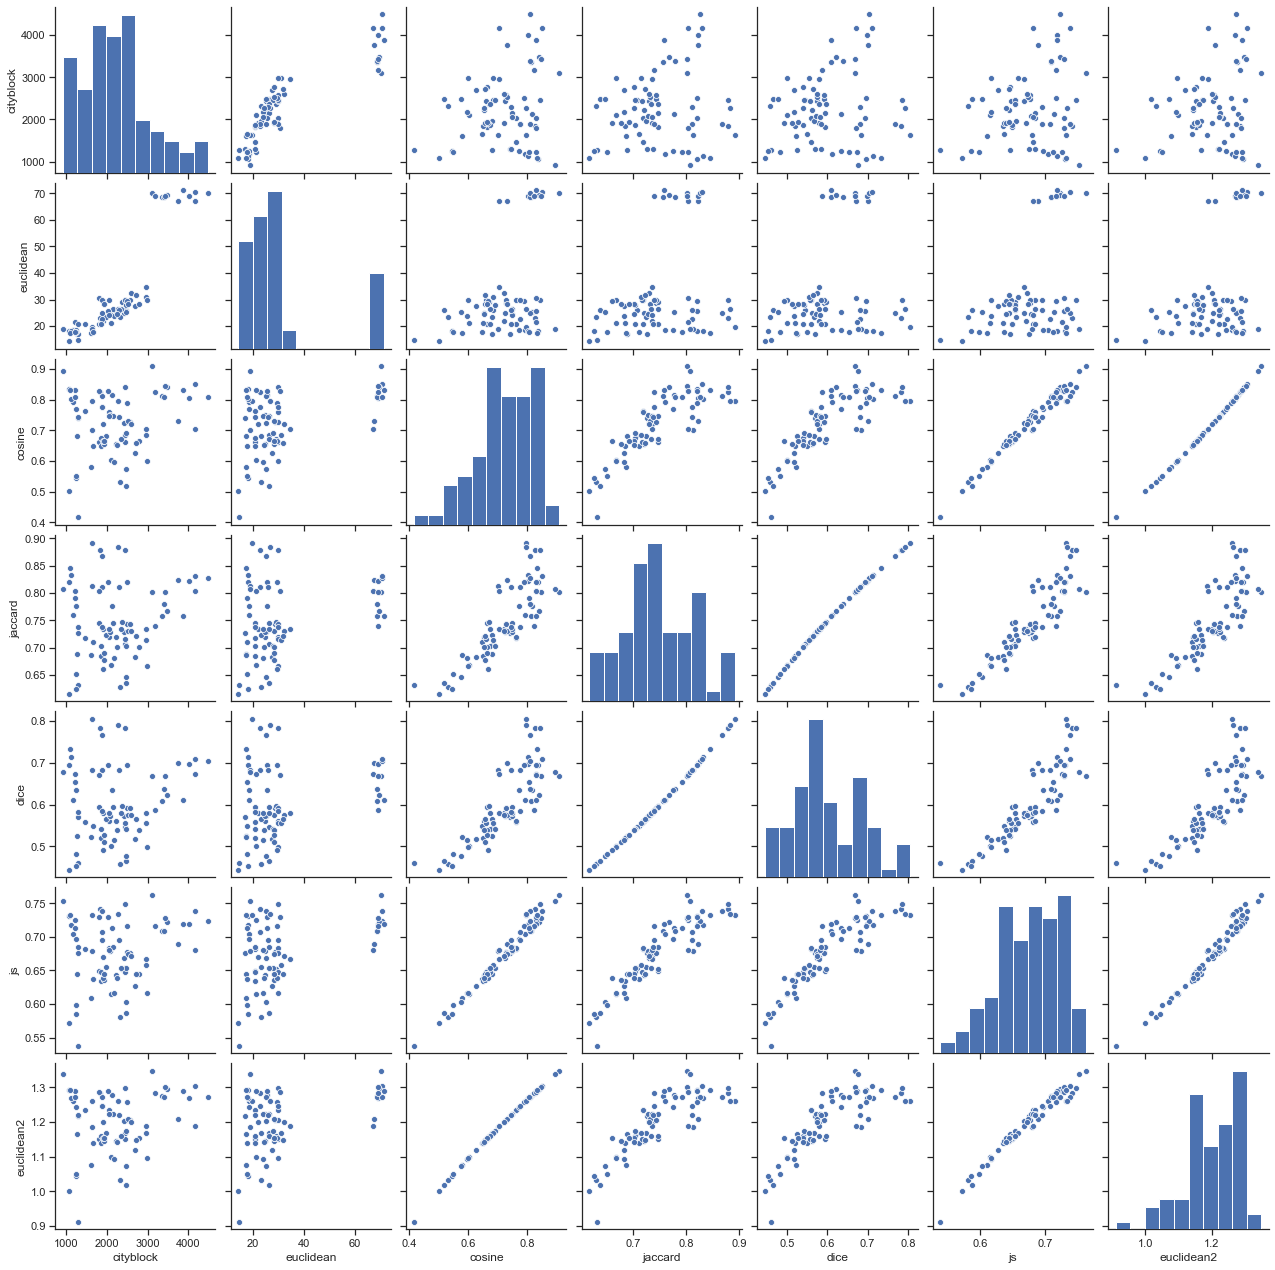

In [79]:
sns.pairplot(SAMPLE);

In [80]:
PAIRS.sort_values('euclidean', ascending=False).head(10).style.background_gradient('YlGn', high=1)

In [81]:
def hca(sims, linkage_method='complete', color_thresh=.3, figsize=(10, 10)):
    tree = sch.linkage(sims, method=linkage_method)
    labels = list(DOC2.title.values)
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)

<Figure size 432x288 with 0 Axes>

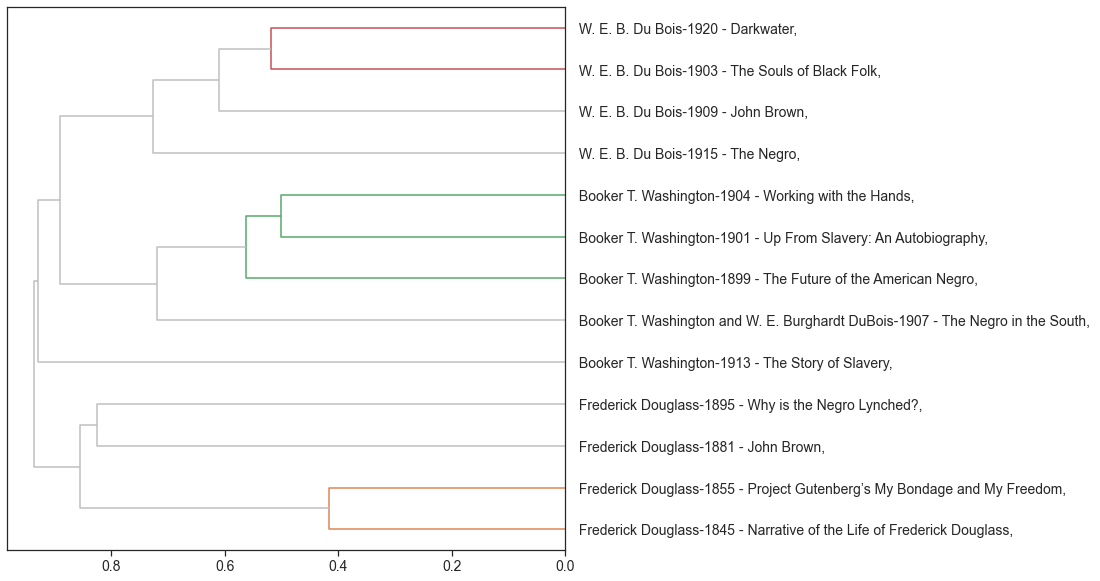

In [82]:
hca(PAIRS.cosine, linkage_method='ward', color_thresh=.6);

<Figure size 432x288 with 0 Axes>

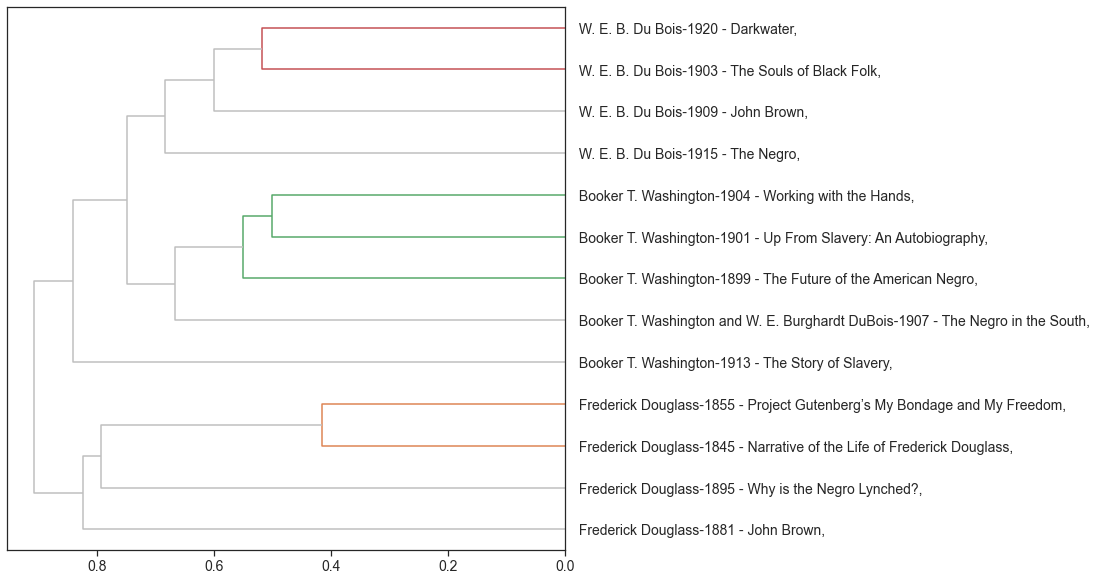

In [83]:
hca(PAIRS.cosine, linkage_method='complete', color_thresh=.6);

<Figure size 432x288 with 0 Axes>

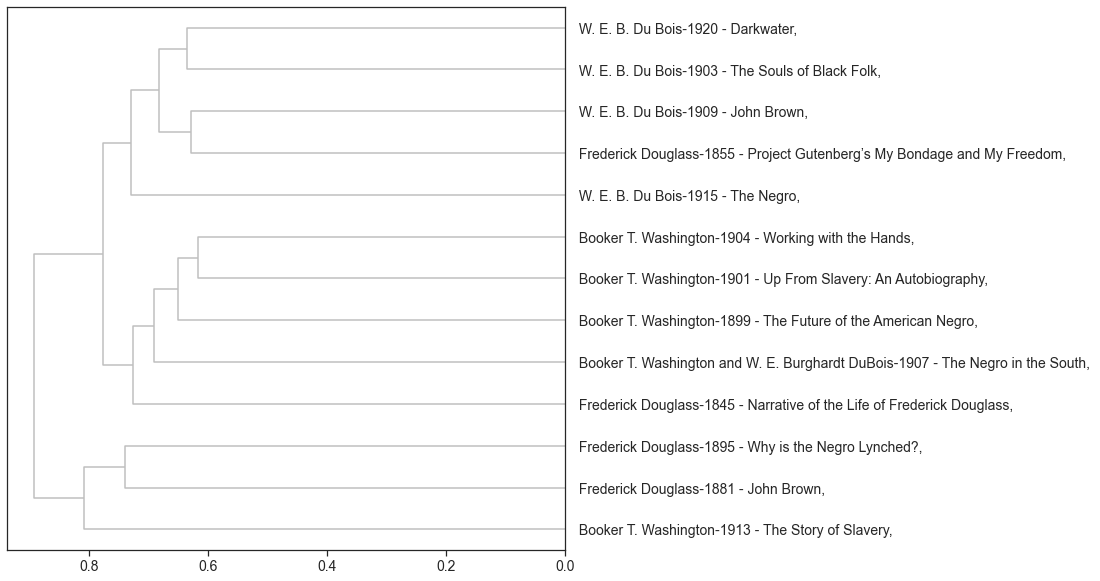

In [84]:
hca(PAIRS.jaccard, color_thresh=.3);

<Figure size 432x288 with 0 Axes>

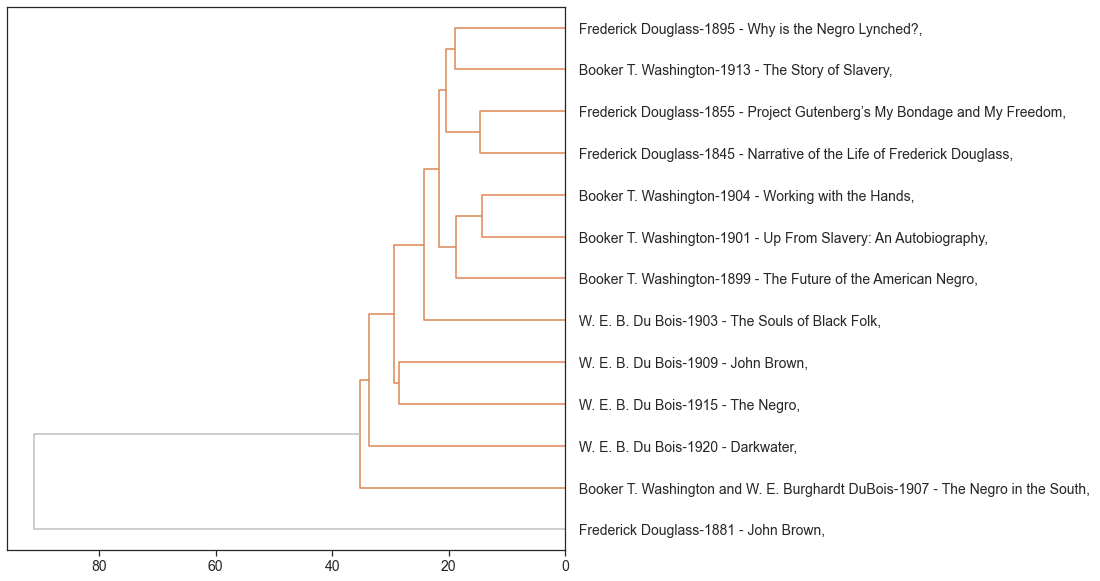

In [85]:
hca(PAIRS.euclidean, linkage_method='ward', color_thresh=48);

<Figure size 432x288 with 0 Axes>

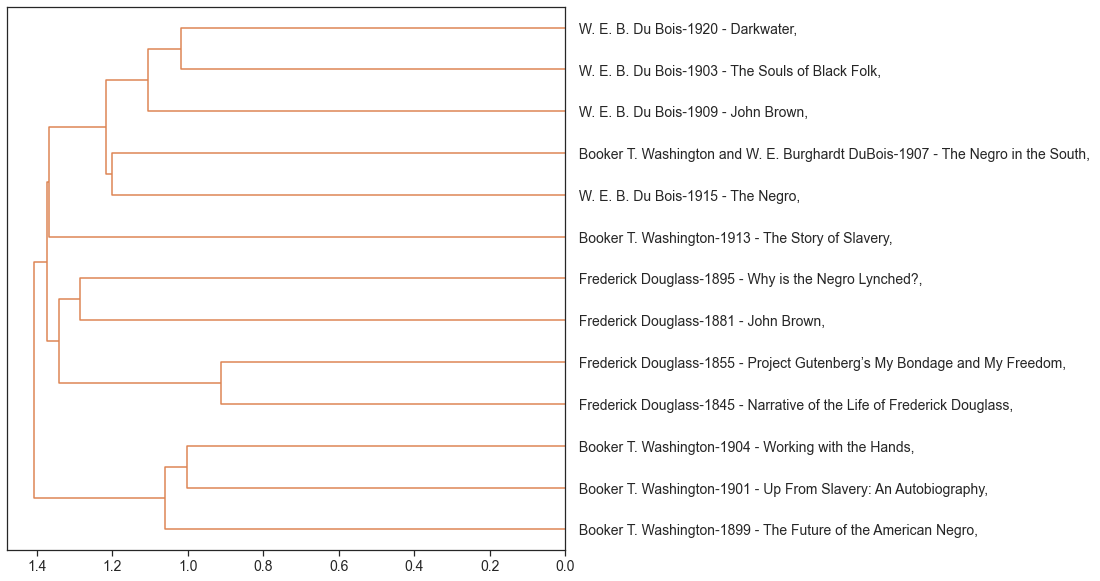

In [86]:
hca(PAIRS.euclidean2, linkage_method='ward', color_thresh=48);

<Figure size 432x288 with 0 Axes>

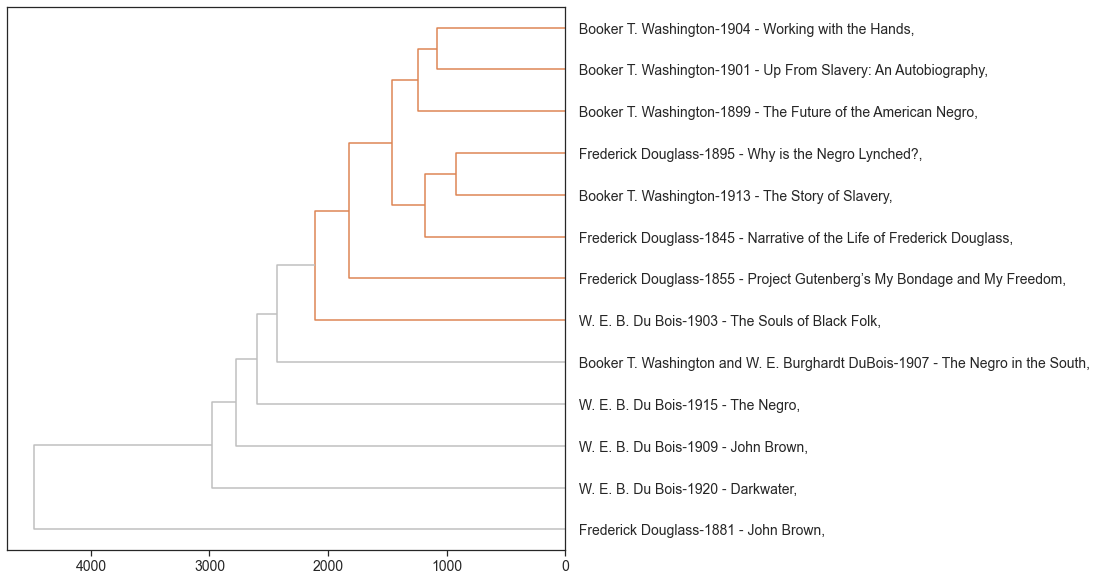

In [87]:
hca(PAIRS.cityblock, color_thresh=2200);

<Figure size 432x288 with 0 Axes>

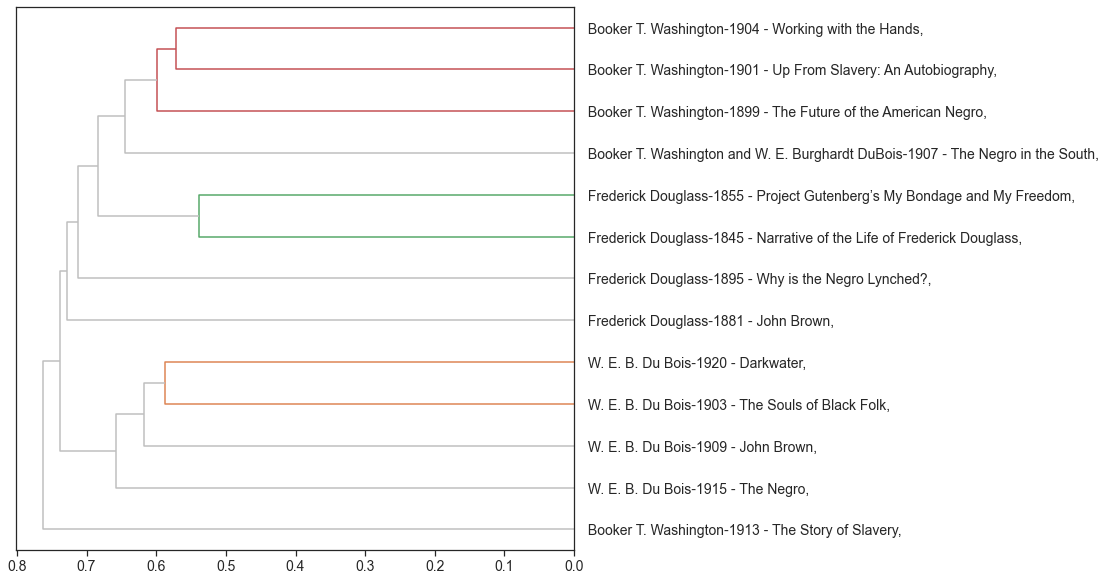

In [88]:
hca(PAIRS.js, color_thresh=.6);

<Figure size 432x288 with 0 Axes>

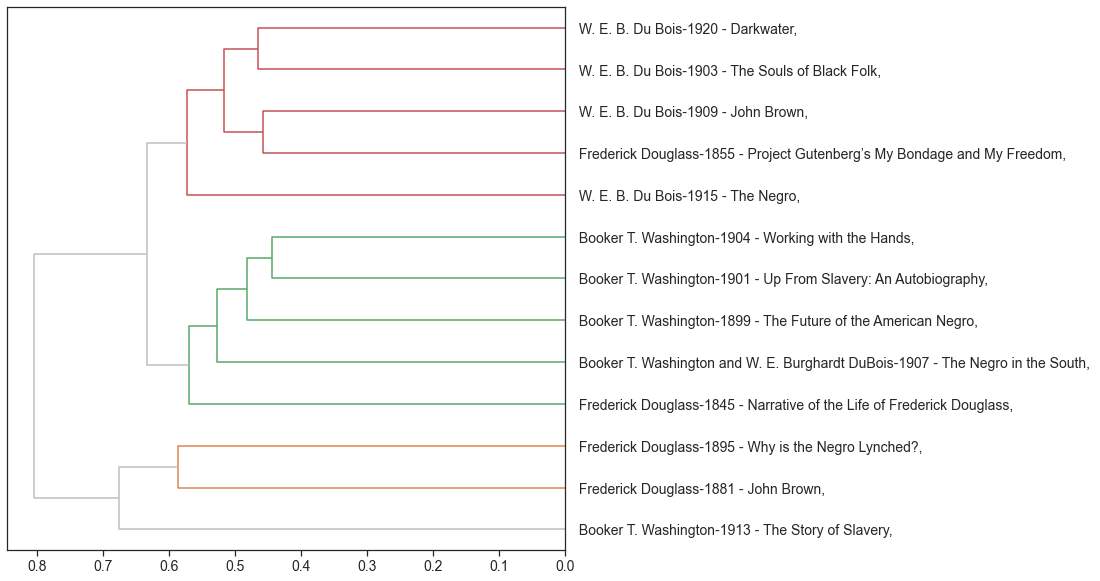

In [89]:
hca(PAIRS.dice, color_thresh=.6);

### Principal component analysis

In [90]:
just_in_case = VOCAB.copy()

In [91]:
pca_VOCAB = VOCAB.copy()

In [92]:
pca_bow, pca_vocab = kaleb_TFIDF(TOKEN, pca_VOCAB, OHCO[:2], 'tf_max4')

In [93]:
pca_vocab.head()

term_id   n  num  stop p_stem  df       idf      dfidf  \
term_str                                                           
01              1   1    1     0     01   1  7.179909   7.179909   
1               2  34    1     0      1  20  2.857981  57.159620   
10              3  19    1     0     10  14  3.372554  47.215758   
100             4  11    1     0    100   7  4.372554  30.607879   
1000            5   8    1     0   1000   6  4.594947  27.569680   

          tfidf_max4_sum  
term_str                  
01              2.885860  
1              23.013347  
10             18.987982  
100            12.307327  
1000           11.074494

Adding TFIDF and TFIDF global term frequency to the vocab table

In [94]:
pca_bow.head()

tf_n   tf_max4  tfidf__max4
book_id chap_num term_str                             
23      1        1835         1  0.406122     1.628545
                 a           50  0.706122     0.000000
                 about        7  0.442857     0.017873
                 absent       1  0.406122     1.078802
                 accurate     1  0.406122     1.866111

In [95]:
TFIDF_temp = pca_bow.tfidf__max4.unstack(fill_value=0)

In [96]:
TFIDF_temp

term_str               01         1        10  100  1000  10000  100000  \
book_id chap_num                                                          
23      1         0.00000  0.000000  0.000000  0.0   0.0    0.0     0.0   
        2         0.00000  0.000000  0.000000  0.0   0.0    0.0     0.0   
        3         0.00000  0.000000  0.000000  0.0   0.0    0.0     0.0   
        4         0.00000  0.000000  0.000000  0.0   0.0    0.0     0.0   
        5         0.00000  0.000000  0.000000  0.0   0.0    0.0     0.0   
...                   ...       ...       ...  ...   ...    ...     ...   
64504   15        0.00000  0.000000  0.000000  0.0   0.0    0.0     0.0   
        16        0.00000  1.169574  1.364587  0.0   0.0    0.0     0.0   
        17        0.00000  0.000000  1.355678  0.0   0.0    0.0     0.0   
        18        0.00000  0.000000  0.000000  0.0   0.0    0.0     0.0   
        19        2.88586  1.148724  1.362077  0.0   0.0    0.0     0.0   

term_str          1000000  10000000  100000000  ...  zulu  zululand  zulus  \
book_id chap_num                                ...                          
23      1             0.0  0.000000        0.0  ...   0.0       0.0    0.0   
        2             0.0  0.000000        0.0  ...   0.0       0.0    0.0   
        3             0.0  0.000000        0.0  ...   0.0       0.0    0.0   
        4             0.0  0.000000        0.0  ...   0.0       0.0    0.0   
        5             0.0  0.000000        0.0  ...   0.0       0.0    0.0   
...                   ...       ...        ...  ...   ...       ...    ...   
64504   15            0.0  0.000000        0.0  ...   0.0       0.0    0.0   
        16            0.0  0.000000        0.0  ...   0.0       0.0    0.0   
        17            0.0  0.000000        0.0  ...   0.0       0.0    0.0   
        18            0.0  0.000000        0.0  ...   0.0       0.0    0.0   
        19            0.0  1.952595        0.0  ...   0.0       0.0    0.0   

term_str          zunis  zymbabwe    à  æschylus  æsop  æsthetic  élite  
book_id chap_num                                                         
23      1           0.0       0.0  0.0       0.0   0.0       0.0    0.0  
        2           0.0       0.0  0.0       0.0   0.0       0.0    0.0  
        3           0.0       0.0  0.0       0.0   0.0       0.0    0.0  
        4           0.0       0.0  0.0       0.0   0.0       0.0    0.0  
        5           0.0       0.0  0.0       0.0   0.0       0.0    0.0  
...                 ...       ...  ...       ...   ...       ...    ...  
64504   15          0.0       0.0  0.0       0.0   0.0       0.0    0.0  
        16          0.0       0.0  0.0       0.0   0.0       0.0    0.0  
        17          0.0       0.0  0.0       0.0   0.0       0.0    0.0  
        18          0.0       0.0  0.0       0.0   0.0       0.0    0.0  
        19          0.0       0.0  0.0       0.0   0.0       0.0    0.0  

[145 rows x 24212 columns]

In [97]:
TFIDF_temp = TFIDF_temp.apply(lambda x:x/norm(x, 2), 1)

In [98]:
pca_vocab['tfidf_sum'] = TFIDF_temp.sum()

In [99]:
tfidf_sum = 'dfidf'
TFIDF_4000 = pca_vocab.sort_values(sum_method, ascending=False)[:4000]

In [100]:
pca_bow['tfidf__max4'].unstack(fill_value=0)

term_str               01         1        10  100  1000  10000  100000  \
book_id chap_num                                                          
23      1         0.00000  0.000000  0.000000  0.0   0.0    0.0     0.0   
        2         0.00000  0.000000  0.000000  0.0   0.0    0.0     0.0   
        3         0.00000  0.000000  0.000000  0.0   0.0    0.0     0.0   
        4         0.00000  0.000000  0.000000  0.0   0.0    0.0     0.0   
        5         0.00000  0.000000  0.000000  0.0   0.0    0.0     0.0   
...                   ...       ...       ...  ...   ...    ...     ...   
64504   15        0.00000  0.000000  0.000000  0.0   0.0    0.0     0.0   
        16        0.00000  1.169574  1.364587  0.0   0.0    0.0     0.0   
        17        0.00000  0.000000  1.355678  0.0   0.0    0.0     0.0   
        18        0.00000  0.000000  0.000000  0.0   0.0    0.0     0.0   
        19        2.88586  1.148724  1.362077  0.0   0.0    0.0     0.0   

term_str          1000000  10000000  100000000  ...  zulu  zululand  zulus  \
book_id chap_num                                ...                          
23      1             0.0  0.000000        0.0  ...   0.0       0.0    0.0   
        2             0.0  0.000000        0.0  ...   0.0       0.0    0.0   
        3             0.0  0.000000        0.0  ...   0.0       0.0    0.0   
        4             0.0  0.000000        0.0  ...   0.0       0.0    0.0   
        5             0.0  0.000000        0.0  ...   0.0       0.0    0.0   
...                   ...       ...        ...  ...   ...       ...    ...   
64504   15            0.0  0.000000        0.0  ...   0.0       0.0    0.0   
        16            0.0  0.000000        0.0  ...   0.0       0.0    0.0   
        17            0.0  0.000000        0.0  ...   0.0       0.0    0.0   
        18            0.0  0.000000        0.0  ...   0.0       0.0    0.0   
        19            0.0  1.952595        0.0  ...   0.0       0.0    0.0   

term_str          zunis  zymbabwe    à  æschylus  æsop  æsthetic  élite  
book_id chap_num                                                         
23      1           0.0       0.0  0.0       0.0   0.0       0.0    0.0  
        2           0.0       0.0  0.0       0.0   0.0       0.0    0.0  
        3           0.0       0.0  0.0       0.0   0.0       0.0    0.0  
        4           0.0       0.0  0.0       0.0   0.0       0.0    0.0  
        5           0.0       0.0  0.0       0.0   0.0       0.0    0.0  
...                 ...       ...  ...       ...   ...       ...    ...  
64504   15          0.0       0.0  0.0       0.0   0.0       0.0    0.0  
        16          0.0       0.0  0.0       0.0   0.0       0.0    0.0  
        17          0.0       0.0  0.0       0.0   0.0       0.0    0.0  
        18          0.0       0.0  0.0       0.0   0.0       0.0    0.0  
        19          0.0       0.0  0.0       0.0   0.0       0.0    0.0  

[145 rows x 24212 columns]

In [103]:
TFIDF_SHORT = TFIDF_temp[TFIDF_4000.index]

In [104]:
def get_pca(X, n_comps=10):
    
    global TFIDF_4000

    COV = X.cov()

    eig_vals, eig_vecs = eigh(COV)
    EIG_VEC = pd.DataFrame(eig_vecs, index=TFIDF_4000.index, columns=TFIDF_4000.index)
    EIG_VAL = pd.DataFrame(eig_vals, index=TFIDF_4000.index, columns=['eig_val'])
    EIG_VAL.index.name = 'term_id'
    EIG_PAIRS = EIG_VAL.join(EIG_VEC.T)
    EIG_PAIRS['exp_var'] = np.round((EIG_PAIRS.eig_val / EIG_PAIRS.eig_val.sum()) * 100, 2)

    COMPS = EIG_PAIRS.sort_values('exp_var', ascending=False).head(n_comps).reset_index(drop=True)
    COMPS.index.name = 'comp_id'
    COMPS.index = ["PC{}".format(i) for i in COMPS.index.tolist()]

    LOADINGS = COMPS[TFIDF_4000.index].T
    LOADINGS.index.name = 'term_str'

    DCM = TFIDF_SHORT.dot(COMPS[TFIDF_4000.index].T)
    DCM = DCM.join(LIB[['Author','title', 'genre']], on='book_id')
#     DCM['title'] = DCM.apply(lambda x: x.name[0] + ', ch '+ str(x.name[1]), 1)
    
    return EIG_PAIRS, COMPS, LOADINGS, DCM
    

In [105]:
TFIDF_SHORT

term_str          students    africa      john  brown  tuskegee  plantation  \
book_id chap_num                                                              
23      1         0.000000  0.019791  0.000000    0.0  0.000000    0.018291   
        2         0.000000  0.000000  0.000000    0.0  0.000000    0.019774   
        3         0.000000  0.000000  0.000000    0.0  0.000000    0.021633   
        4         0.000000  0.000000  0.000000    0.0  0.000000    0.020082   
        5         0.000000  0.000000  0.000000    0.0  0.000000    0.022280   
...                    ...       ...       ...    ...       ...         ...   
64504   15        0.019830  0.000000  0.000000    0.0  0.021390    0.000000   
        16        0.027453  0.000000  0.000000    0.0  0.026313    0.000000   
        17        0.015187  0.000000  0.013243    0.0  0.017839    0.012406   
        18        0.019346  0.016385  0.015643    0.0  0.022035    0.014512   
        19        0.000000  0.014678  0.000000    0.0  0.017721    0.000000   

term_str          coloured     crime     labor    cotton  ...  influenced  \
book_id chap_num                                          ...               
23      1         0.000000  0.000000  0.019791  0.000000  ...    0.000000   
        2         0.000000  0.000000  0.000000  0.000000  ...    0.000000   
        3         0.000000  0.000000  0.000000  0.000000  ...    0.000000   
        4         0.000000  0.020930  0.000000  0.000000  ...    0.000000   
        5         0.000000  0.000000  0.000000  0.000000  ...    0.000000   
...                    ...       ...       ...       ...  ...         ...   
64504   15        0.019740  0.000000  0.000000  0.000000  ...    0.000000   
        16        0.024113  0.000000  0.000000  0.000000  ...    0.000000   
        17        0.015922  0.000000  0.000000  0.013951  ...    0.035015   
        18        0.018795  0.000000  0.000000  0.017149  ...    0.000000   
        19        0.017314  0.014273  0.000000  0.015028  ...    0.000000   

term_str          hosts  convictions  counter  bitterly  sufferings  \
book_id chap_num                                                      
23      1           0.0          0.0      0.0       0.0         0.0   
        2           0.0          0.0      0.0       0.0         0.0   
        3           0.0          0.0      0.0       0.0         0.0   
        4           0.0          0.0      0.0       0.0         0.0   
        5           0.0          0.0      0.0       0.0         0.0   
...                 ...          ...      ...       ...         ...   
64504   15          0.0          0.0      0.0       0.0         0.0   
        16          0.0          0.0      0.0       0.0         0.0   
        17          0.0          0.0      0.0       0.0         0.0   
        18          0.0          0.0      0.0       0.0         0.0   
        19          0.0          0.0      0.0       0.0         0.0   

term_str          conquering  confused  scarred  veiled  
book_id chap_num                                         
23      1                0.0       0.0      0.0     0.0  
        2                0.0       0.0      0.0     0.0  
        3                0.0       0.0      0.0     0.0  
        4                0.0       0.0      0.0     0.0  
        5                0.0       0.0      0.0     0.0  
...                      ...       ...      ...     ...  
64504   15               0.0       0.0      0.0     0.0  
        16               0.0       0.0      0.0     0.0  
        17               0.0       0.0      0.0     0.0  
        18               0.0       0.0      0.0     0.0  
        19               0.0       0.0      0.0     0.0  

[145 rows x 4000 columns]

In [125]:
def vis_pcs(M, a, b, label='Author', prefix='PC', symbol=None):
    fig = px.scatter(M, prefix + str(a), prefix + str(b), 
                        color=label,
                        hover_name='Author',
                        hover_data=['title'],
                        marginal_x='box',
                        symbol=symbol,
                        height=800)
    fig.show()

In [107]:
EIG_PAIRS, COMPS, LOADINGS, DCM = get_pca(TFIDF_SHORT)

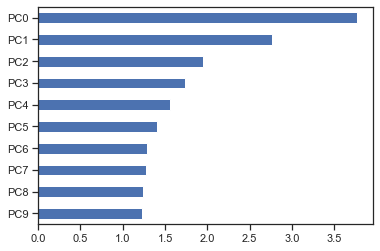

In [108]:
COMPS.exp_var.sort_values().plot.barh();

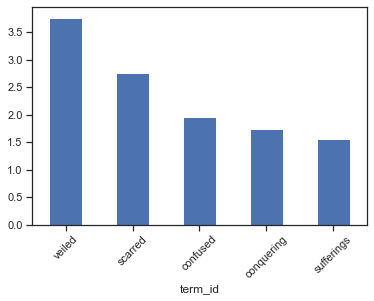

In [109]:
EIG_PAIRS.exp_var.sort_values(ascending=False).head().plot.bar(rot=45)

In [110]:
LOADINGS.head(10).style.background_gradient(cmap='YlGn', high=.5)

## PCA 0 and 1

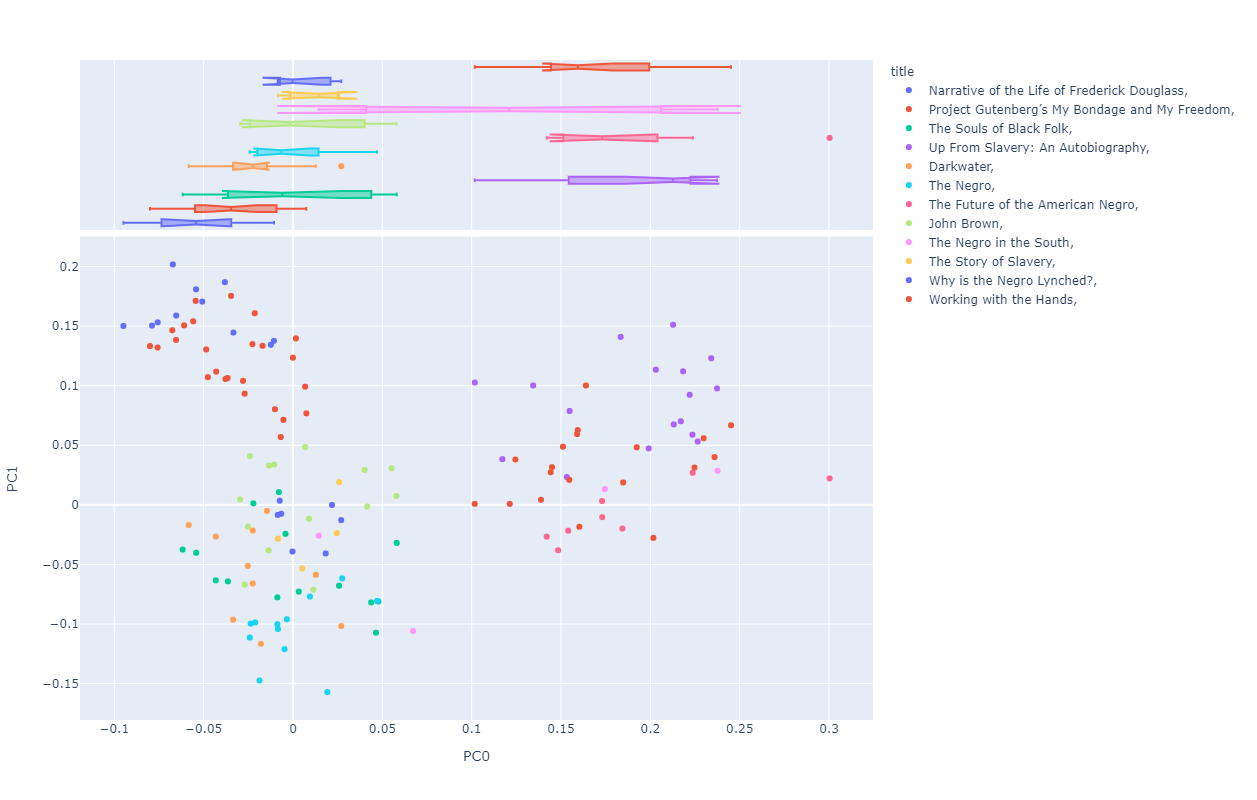

In [126]:
vis_pcs(DCM, 0, 1, label='title')

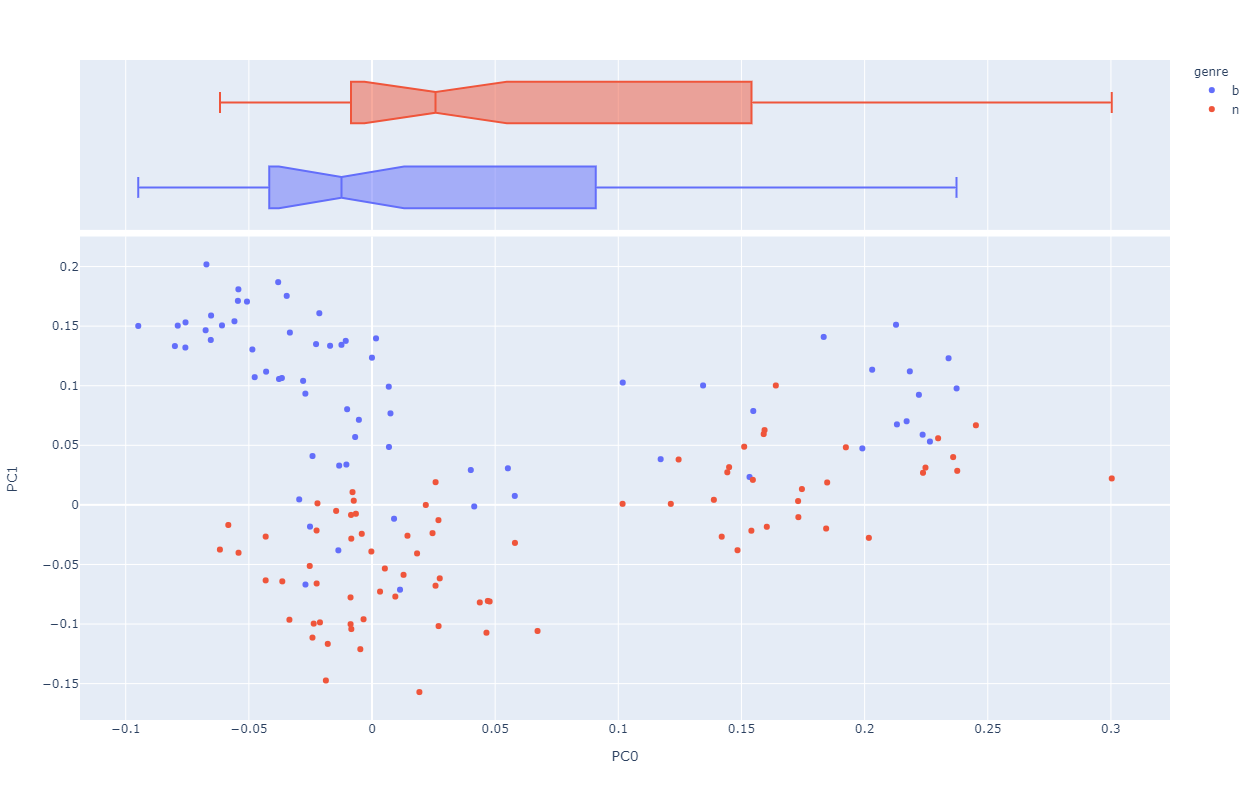

In [127]:
vis_pcs(DCM, 0, 1, label='genre')

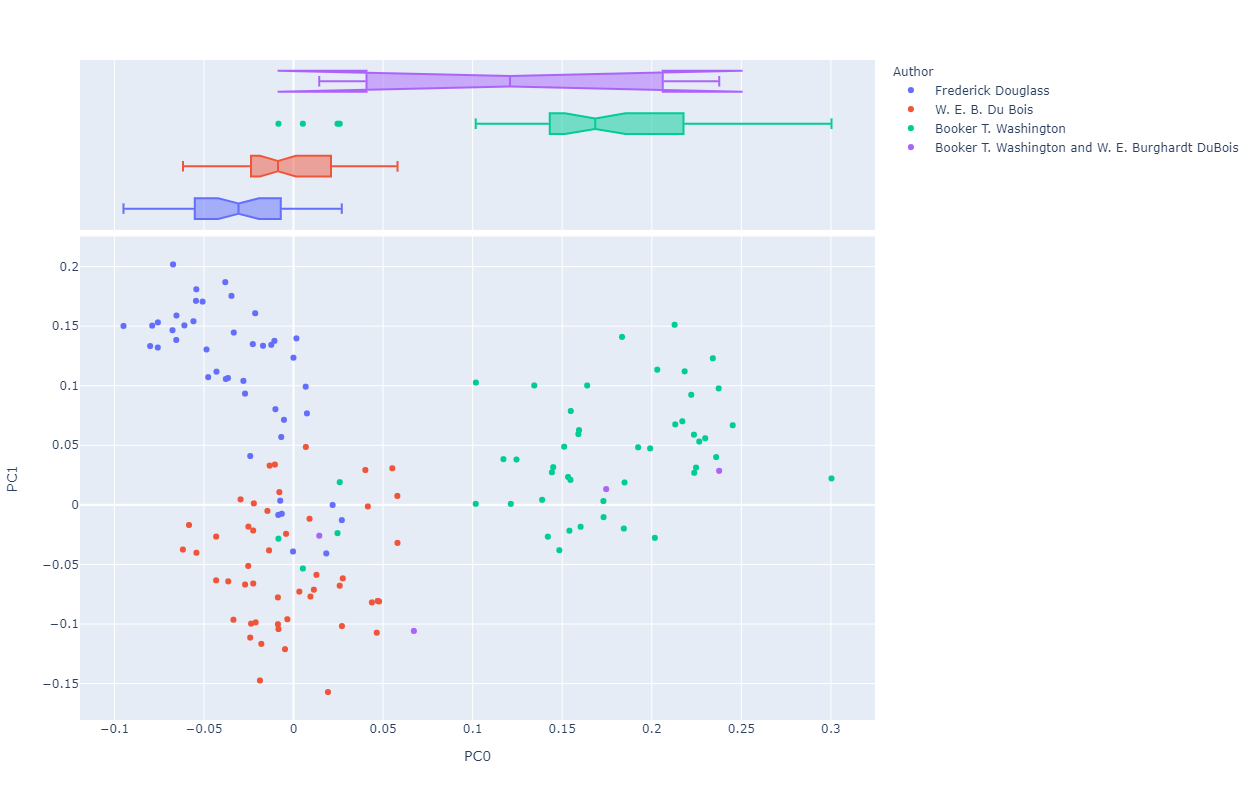

In [128]:
vis_pcs(DCM, 0, 1, label='Author')

## PCA 1 and 2

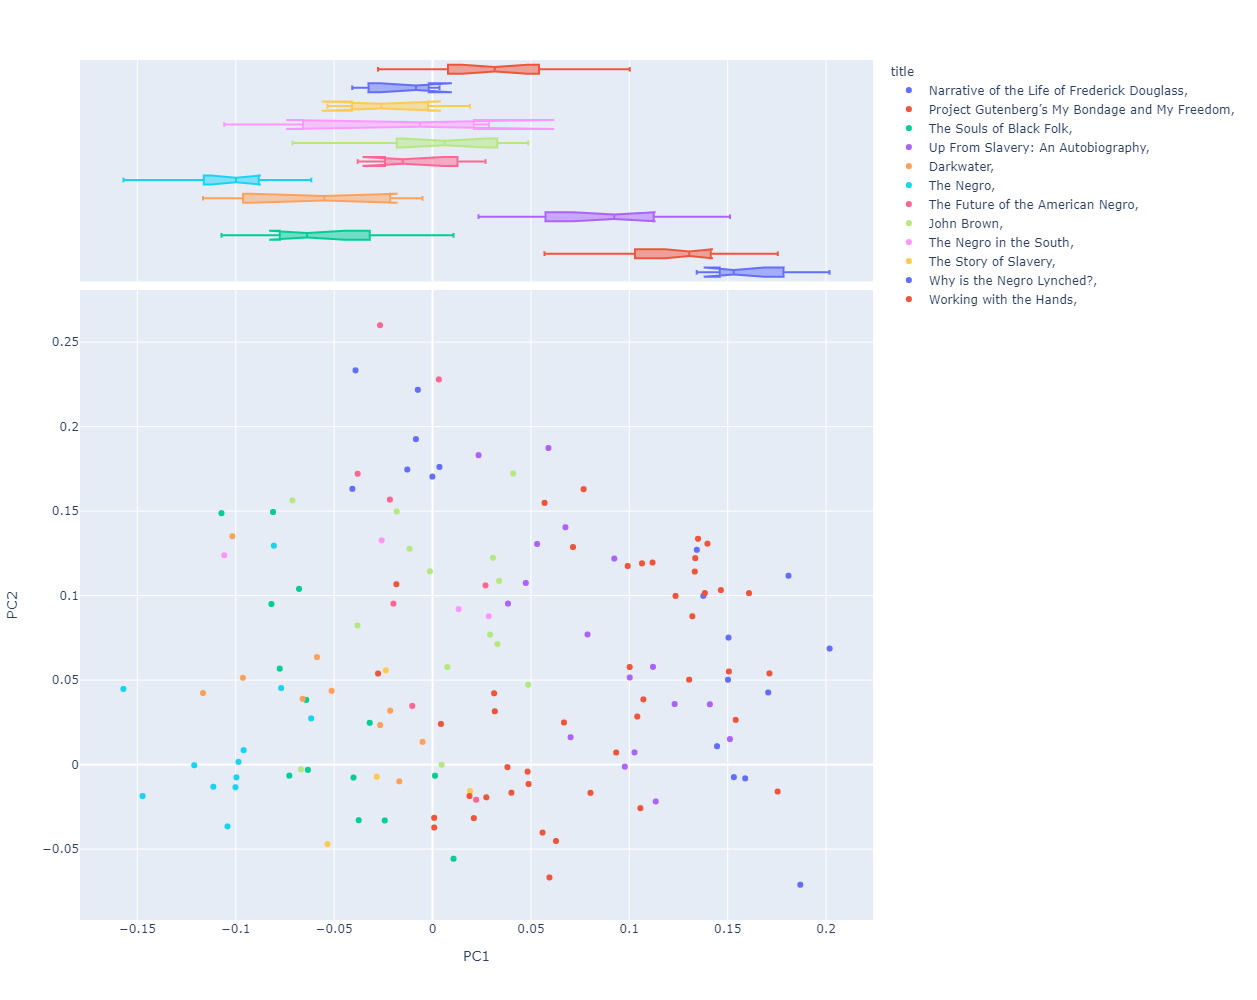

In [118]:
vis_pcs(DCM, 1, 2, label='title')

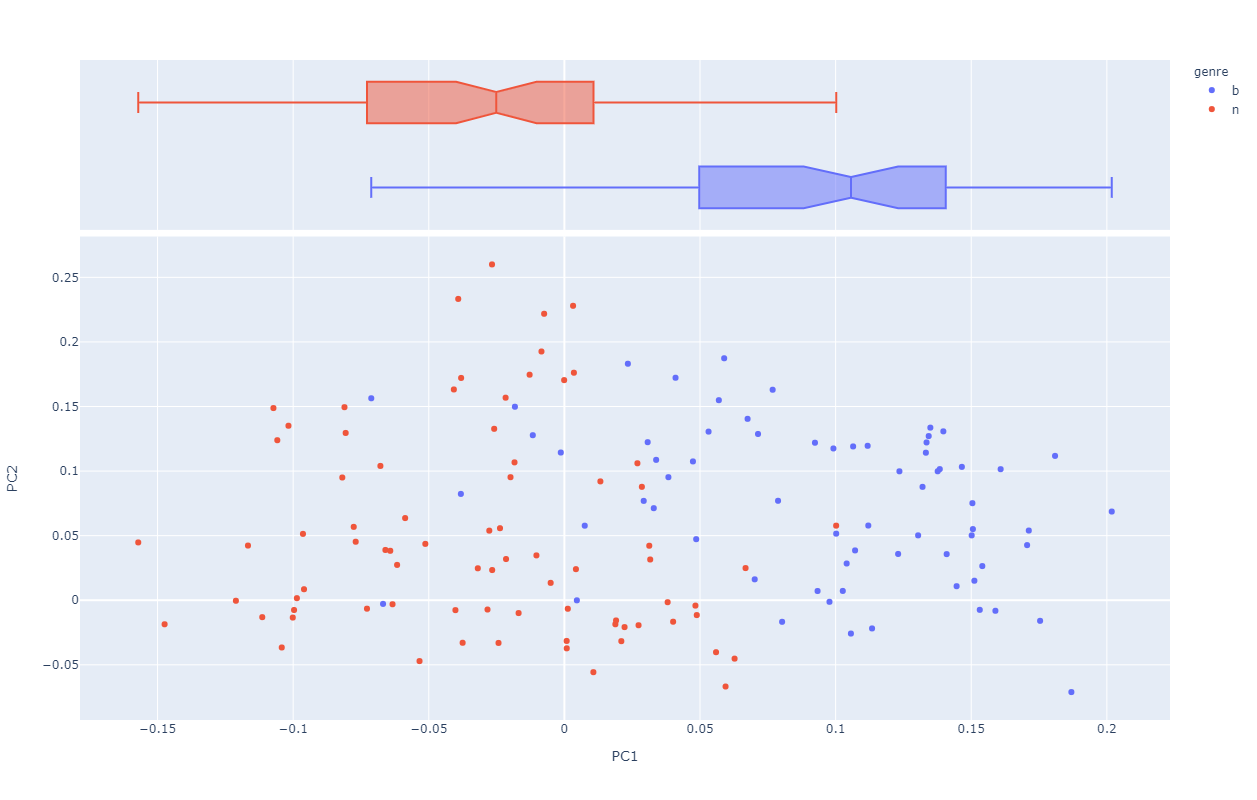

In [129]:
vis_pcs(DCM, 1, 2, label='genre')

## PCA 2 and 3

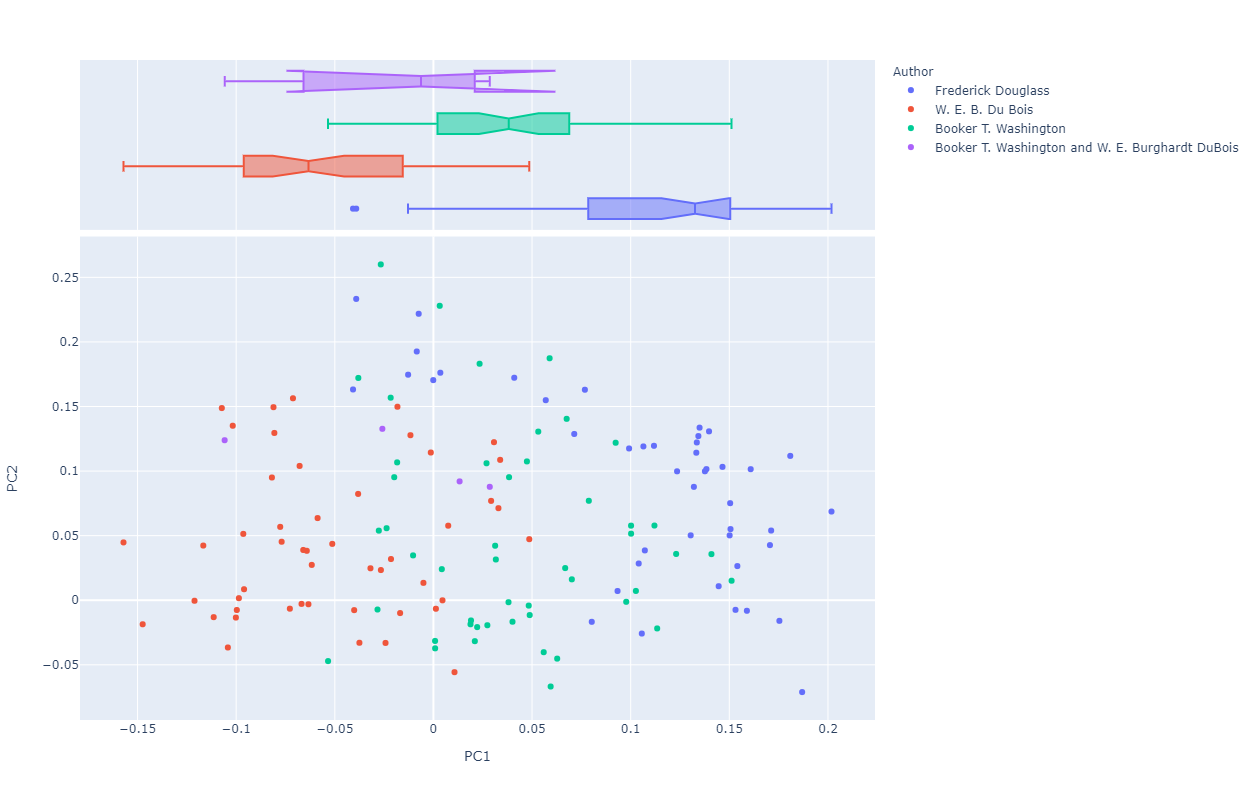

In [130]:
vis_pcs(DCM, 1, 2, label='Author')

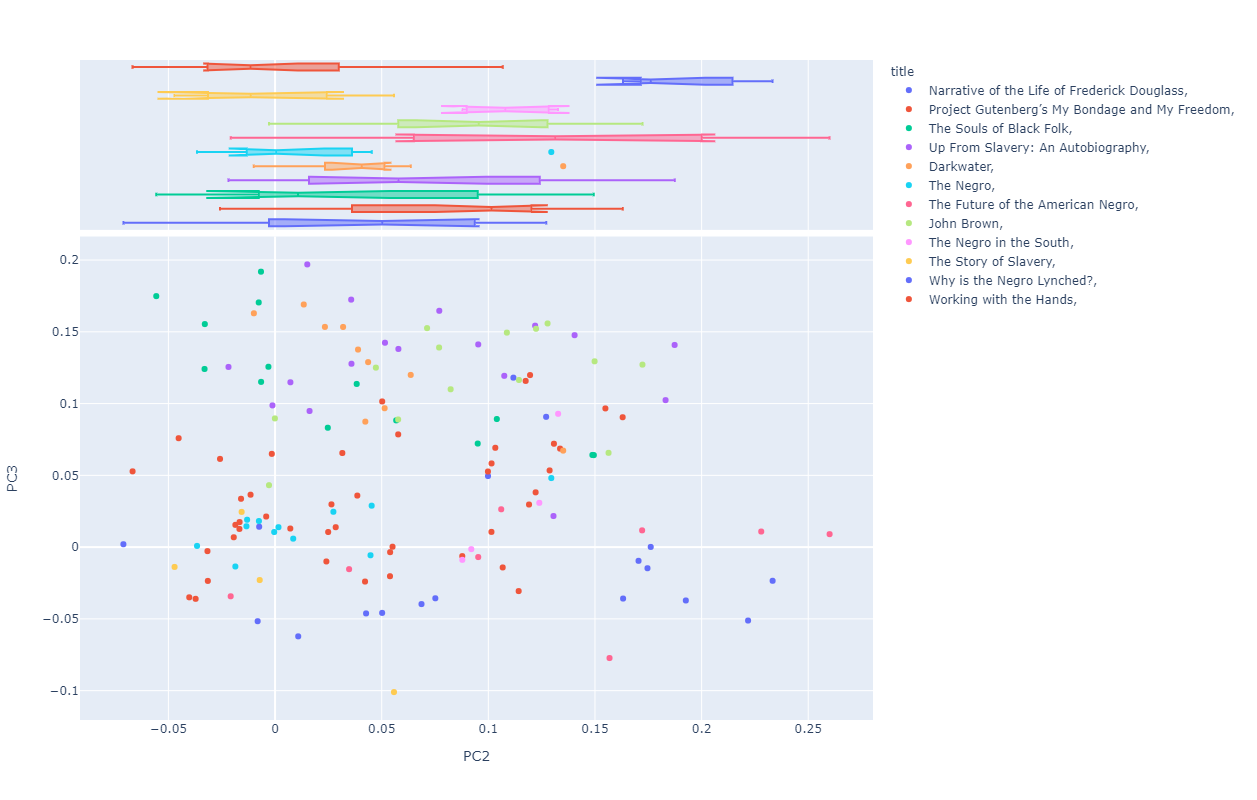

In [131]:
vis_pcs(DCM, 2, 3, label='title')

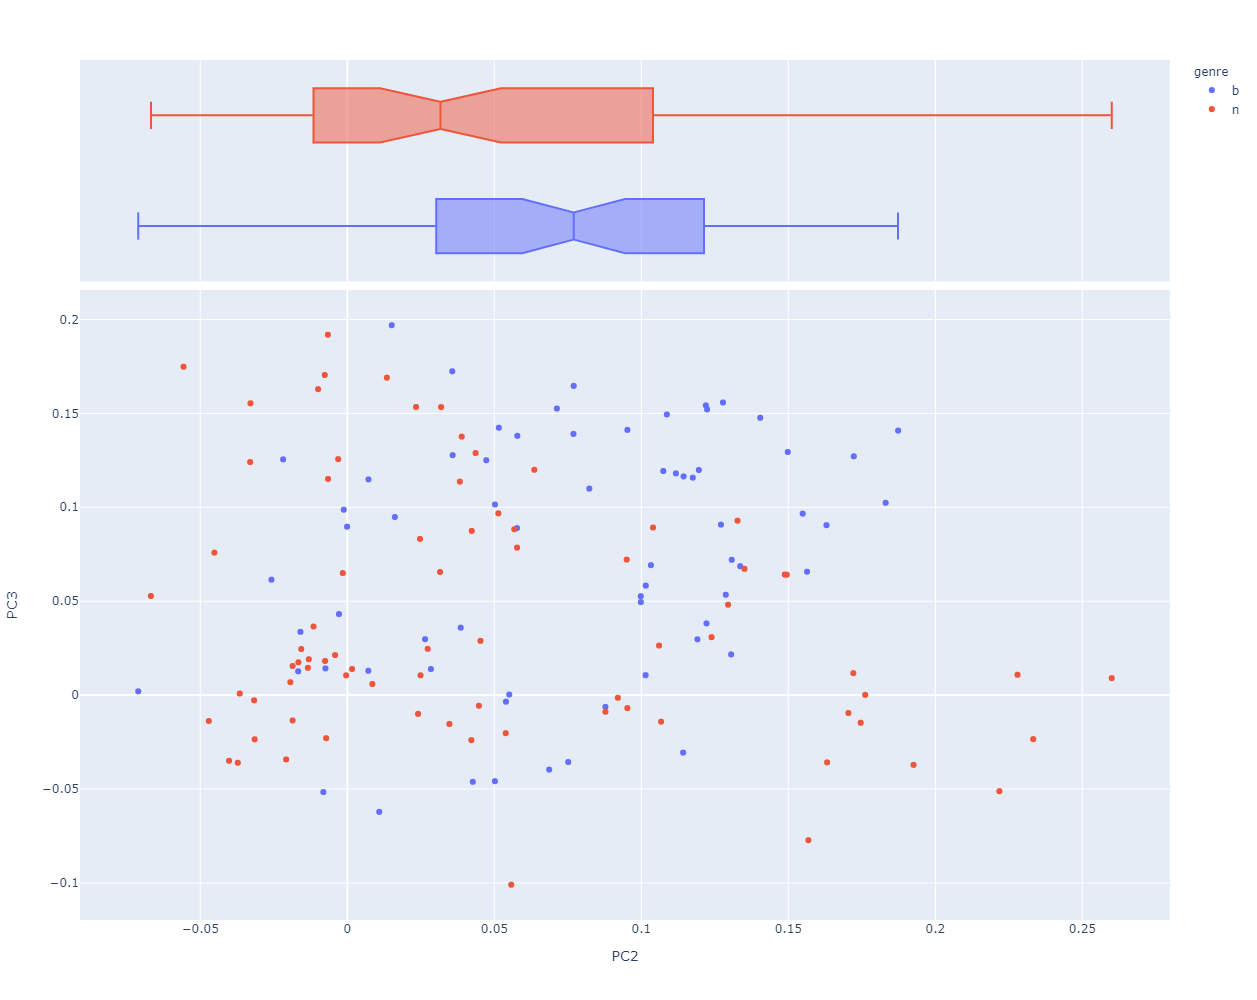

In [122]:
vis_pcs(DCM, 2, 3, label='genre')

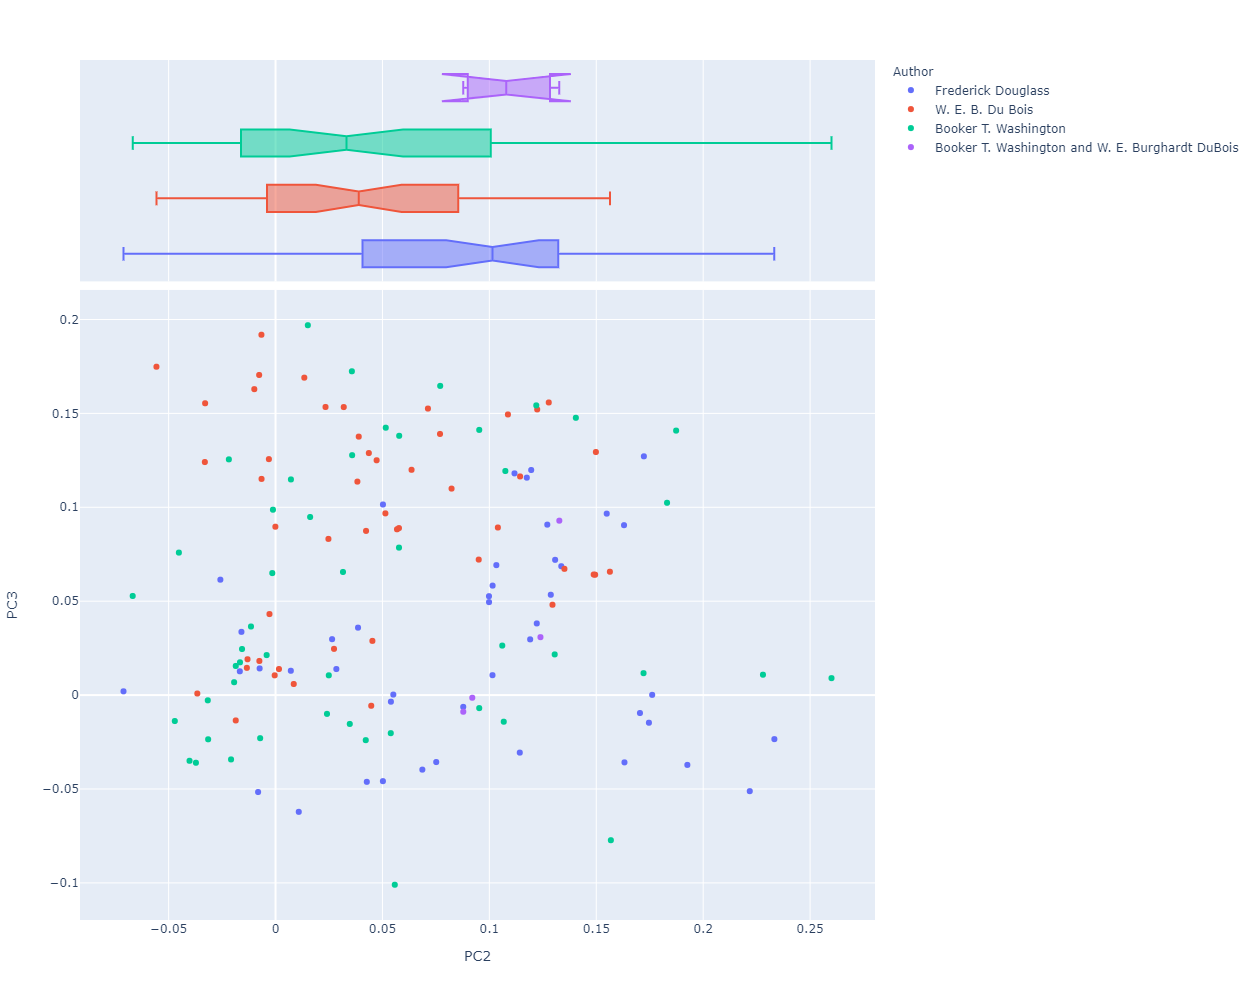

In [123]:
vis_pcs(DCM, 2, 3, label='Author')

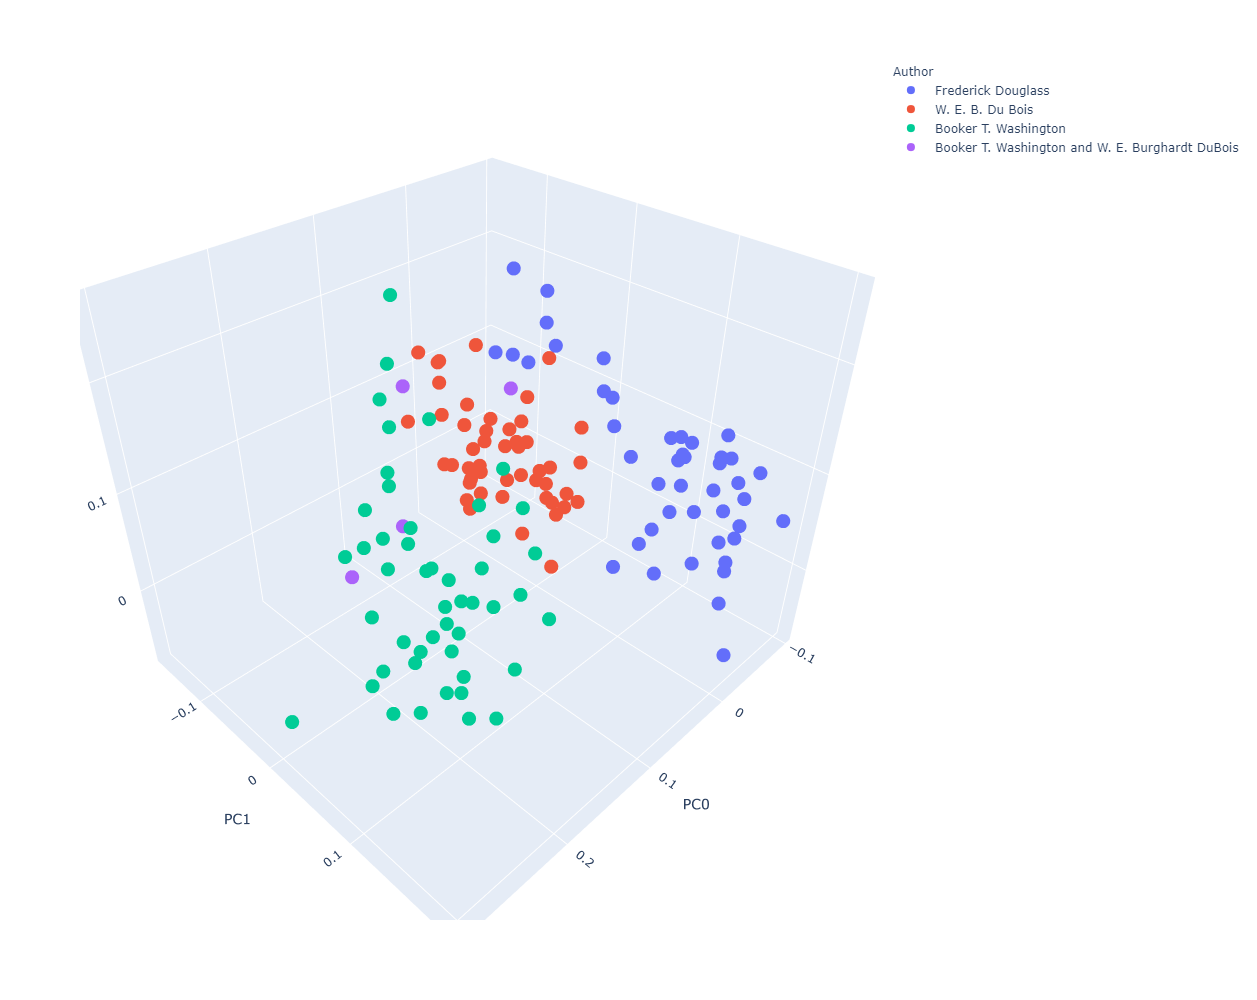

In [124]:
px.scatter_3d(DCM, 'PC0', 'PC1', 'PC2', color='Author', height=1000, hover_name='Author',
                        hover_data=['title'])

## TOPIC MODELS

In [134]:
# OHCO = ['book_id', 'chap_num', 'para_num']
PARA = OHCO[:3]
CHAP = OHCO[:2]
BOOK = OHCO[:1]

In [135]:
BAG = CHAP

In [136]:
ngram_range = [1,2]
n_terms = 4000
n_topics = 40
max_iter = 20
n_top_terms = 10

In [137]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [138]:
TOKEN['term_str'] = TOKEN['term_str'].astype(str)

In [139]:
DOCS = TOKEN[TOKEN.pos.str.match(r'^NNS?$')]\
    .groupby(BAG).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'doc_str'})

In [140]:
DOCS

doc_str
book_id chap_num                                                   
23      1         miles county knowledge age record containing i...
        2         masters family sons daughter husband house hom...
        3         garden employment men gardener mr mdurmond gar...
        4         time office overseer career severity man posse...
        5         treatment slave children field field work deal...
...                                                             ...
64504   15        lifetime work value things day round students ...
        16        growth institution lines side school years cha...
        17        founding enrollment men women degree thousand ...
        18        questions extent graduates work parent institu...
        19        persons position point view attempts education...

[145 rows x 1 columns]

In [141]:
count_engine = CountVectorizer(max_features=n_terms, ngram_range=ngram_range, stop_words='english')
count_model = count_engine.fit_transform(DOCS.doc_str)
TERMS = count_engine.get_feature_names()

In [142]:
lda_engine = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)

## THETA

In [143]:
THETA = pd.DataFrame(lda_engine.fit_transform(count_model), index=DOCS.index)
THETA.columns.name = 'topic_id'

In [144]:
THETA.sample(20).style.background_gradient()

## PHI

In [145]:
PHI = pd.DataFrame(lda_engine.components_, columns=TERMS)
PHI.index.name = 'topic_id'
PHI.columns.name  = 'term_str'

In [146]:
PHI.T.sample(10).style.background_gradient()

## TOPICS

In [147]:
TOPICS = PHI.stack().to_frame().rename(columns={0:'topic_weight'})\
    .groupby('topic_id')\
    .apply(lambda x: 
        x.sort_values('topic_weight', ascending=False)\
               .head(n_top_terms)\
               .reset_index()\
               .drop('topic_id',1)['term_str'])

In [148]:
TOPICS[[t for t in range(n_top_terms)]]

term_str           0           1              2          3             4  \
topic_id                                                                   
0                men     liberty        freedom      color           son   
1              money     dollars           work     people          time   
2             people         men        problem        mob         crime   
3             slaves       cabin     plantation     family        mother   
4            address    audience           time    meeting        speech   
5         abhorrence   privilege          pride     priest       priests   
6            slavery         men         slaves        day          land   
7             mother    children          child      house    plantation   
8           stranger         man            nan    service           men   
9         abhorrence   privilege          pride     priest       priests   
10        abhorrence   privilege          pride     priest       priests   
11        abhorrence   privilege          pride     priest       priests   
12             world         men            nan        man          life   
13        abhorrence   privilege          pride     priest       priests   
14             world        life            nan      songs           day   
15               men       state           time        man        slaves   
16             slave      slaves           time        man        master   
17        abhorrence   privilege          pride     priest       priests   
18             labor       house         county   children          life   
19          students      school           work       farm       student   
20        abhorrence   privilege          pride     priest       priests   
21             women    children          world        men        mother   
22             trade     century          coast    culture        people   
23           slavery         man          slave        men        people   
24               men        type           race      world          hair   
25            master       slave            man    slavery      overseer   
26            school      people           work       time     education   
27              land      cotton          acres        man          crop   
28              race      people            man  education         years   
29              wool    business  manufacturers     family        prices   
30        abhorrence   privilege          pride     priest       priests   
31            slaves  plantation            man      slave      overseer   
32        abhorrence   privilege          pride     priest       priests   
33            slaves      master            man      slave  slaveholders   
34             world     peoples            men   colonies  exploitation   
35            charge       times           time    purpose         women   
36               men       world       industry      today    government   
37             slave        time       mistress    slavery          book   
38              home       women           room      girls      children   
39              work     student         course   students         study   

term_str          5          6          7              8             9  
topic_id                                                                
0             birth      years        man      carpenter         greed  
1            school   building        man           help   opportunity  
2               man        law     charge           case       country  
3          children      place    freedom         people         house  
4            people       work       race       platform     committee  
5          princess  principal  principle     principles         print  
6           freedom       life       time          slave        nation  
7            father     master    slavery           home          life  
8              face   servants      house           eyes       colonel  
9   

In [149]:
TOPICS['label'] = TOPICS.apply(lambda x: str(x.name) + ' ' + ', '.join(x[:n_top_terms]), 1)

In [150]:
TOPICS['doc_weight_avg'] = THETA.mean()

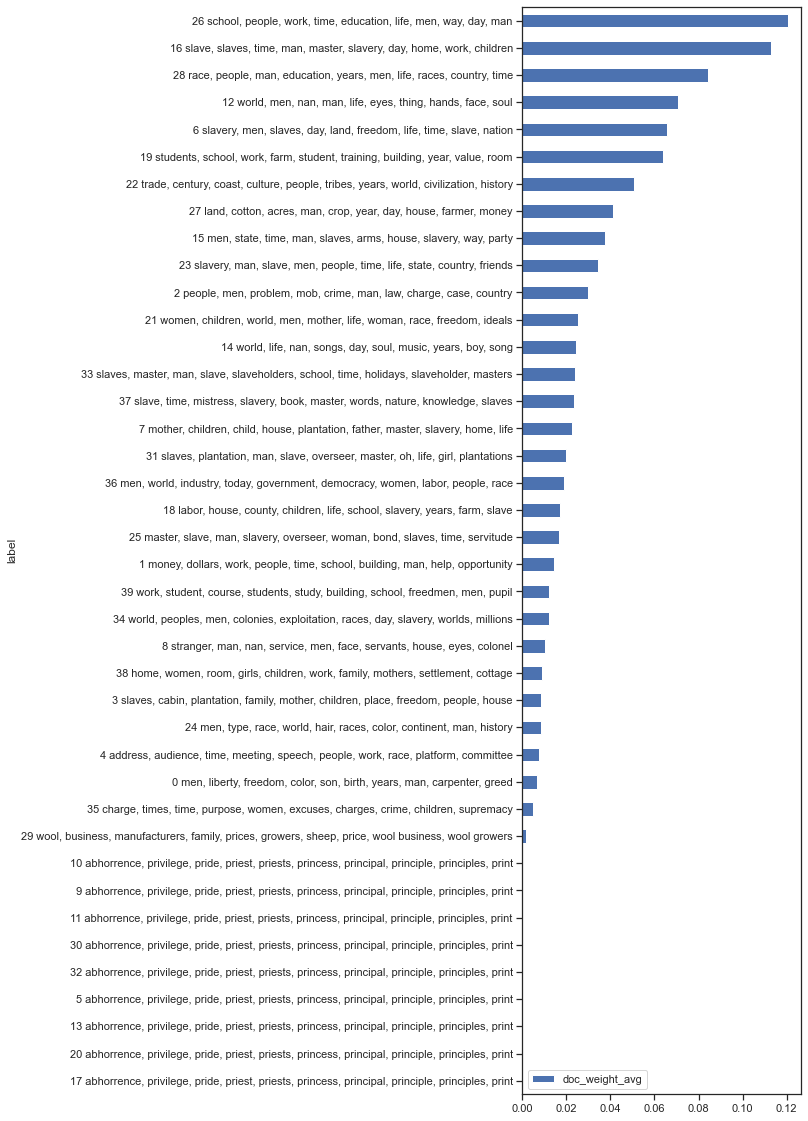

In [151]:
TOPICS.sort_values('doc_weight_avg', ascending=True).plot.barh(y='doc_weight_avg', x='label', figsize=(5,n_topics/2));

In [152]:
topic_cols = [t for t in range(n_topics)]
GENRES = THETA.join(LIB, on='book_id')\
    .reset_index().set_index(['genre']+BAG)\
    .groupby('genre')[topic_cols].mean()\
    .T                                            
GENRES.index.name = 'topic_id'

In [153]:
GENRES['label'] = TOPICS['label']

In [154]:
GENRES.sort_values('n', ascending=False).style.background_gradient()

In [155]:
GENRES.sort_values('b', ascending=False).style.background_gradient()

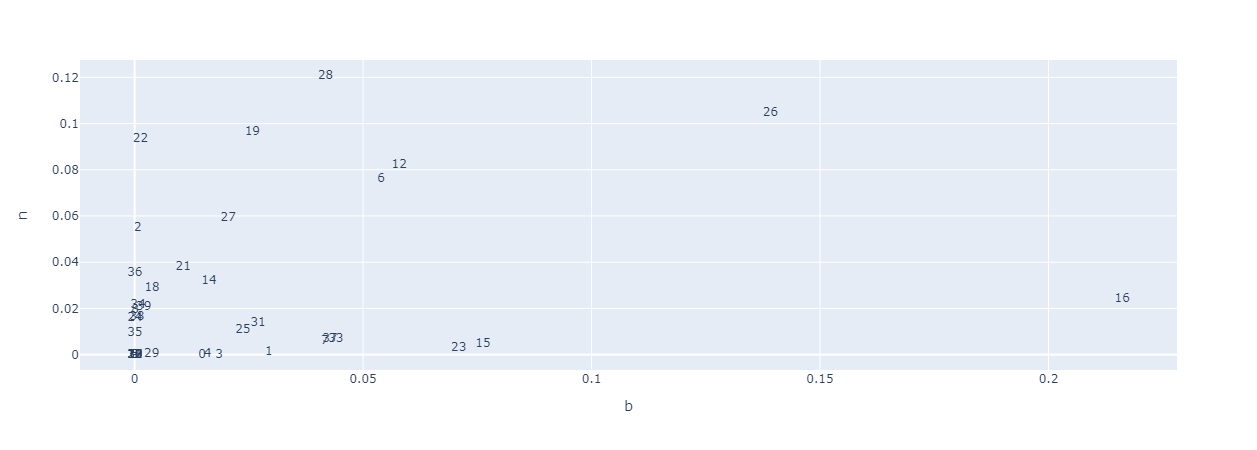

In [156]:
px.scatter(GENRES.reset_index(), 'b', 'n', hover_name='label', text='topic_id', width=600)\
    .update_traces(mode='text')

# Word Embedding

In [157]:
from gensim.models import word2vec
from sklearn.manifold import TSNE

In [158]:
w2v_params = dict(
    window = 5,
    vector_size = 246,
    min_count = 50,
    workers = 4
)

In [159]:
TOKEN

book_id  chap_num  para_num  sent_num  token_num           pos_tuple  \
0           202         1         0         0          0     ('PLACE', 'NN')   
1           202         1         0         0          1       ('OF', 'NNP')   
2           202         1         0         0          2    ('BIRTH', 'NNP')   
3           202         1         0         0          3          ('-', ':')   
4           202         1         0         0          4          ('-', ':')   
...         ...       ...       ...       ...        ...                 ...   
693642    45125         4        34         1         25  ('brighter', 'NN')   
693643    45125         4        34         1         26       ('and', 'CC')   
693644    45125         4        34         1         27     ('more', 'RBR')   
693645    45125         4        34         1         28  ('cheerful', 'JJ')   
693646    45125         4        34         1         29     ('view.', 'NN')   

        pos token_str  term_str  
0        NN     PLACE     place  
1       NNP        OF        of  
2       NNP     BIRTH     birth  
3         :         -       nan  
4         :         -       nan  
...     ...       ...       ...  
693642   NN  brighter  brighter  
693643   CC       and       and  
693644  RBR      more      more  
693645   JJ  cheerful  cheerful  
693646   NN     view.      view  

[693647 rows x 9 columns]

In [160]:
pos = ['NN', 'NNS', 'VB', 'VBD', 'VBG', 'VBN','VBP', 'VBZ']

In [161]:
Fredrick_Token_noun_verb = Fredrick_Token.set_index(OHCO)#[Fredrick_Token.pos.isin(pos)].set_index(OHCO)
Booker_Token_noun_verb = Booker_Token.set_index(OHCO)#[Booker_Token.pos.isin(pos)].set_index(OHCO)
Bois_Token_noun_verb = Bois_Token.set_index(OHCO)#[Bois_Token.pos.isin(pos)].set_index(OHCO)

In [162]:
Bois_Token_noun_verb

pos_tuple   pos  \
book_id chap_num para_num sent_num token_num                                   
408     1        0        0        0                      ('Of', 'IN')    IN   
                                   1                   ('Our', 'PRP$')  PRP$   
                                   2               ('Spiritual', 'JJ')    JJ   
                                   3              ('Strivings', 'NNS')   NNS   
                 1        0        0                      ('O', 'NNP')   NNP   
...                                                                ...   ...   
35399   4        118      0        4                ('Atlanta', 'NNP')   NNP   
                                   5             ('University', 'NNP')   NNP   
                                   6          ('Publications,', 'NNP')   NNP   
                                   7                     ('No.', 'NN')    NN   
                          1        0                      ('8.', 'CD')    CD   

                                                  token_str      term_str  
book_id chap_num para_num sent_num token_num                               
408     1        0        0        0                     Of            of  
                                   1                    Our           our  
                                   2              Spiritual     spiritual  
                                   3              Strivings     strivings  
                 1        0        0                      O             o  
...                                                     ...           ...  
35399   4        118      0        4                Atlanta       atlanta  
                                   5             University    university  
                                   6          Publications,  publications  
                                   7                    No.            no  
                          1        0                     8.             8  

[319495 rows x 4 columns]

In [163]:
PARA = OHCO[:4]

In [164]:
FredrickDOCS = Fredrick_Token_noun_verb.groupby(PARA)\
        .term_str.apply(lambda  x:  x.tolist())\
        .reset_index()['term_str'].tolist()

BookerDOCS = Booker_Token_noun_verb.groupby(PARA)\
        .term_str.apply(lambda  x:  x.tolist())\
        .reset_index()['term_str'].tolist()

BoisDOCS = Bois_Token_noun_verb.groupby(PARA)\
        .term_str.apply(lambda  x:  x.tolist())\
        .reset_index()['term_str'].tolist()


In [165]:
FredrickDOCS = [doc for doc in FredrickDOCS if len(doc)>1]
BookerDOCS = [doc for doc in BookerDOCS if len(doc)>1]
BoisDOCS = [doc for doc in BoisDOCS if len(doc)>1]

In [166]:
model_fredrick = word2vec.Word2Vec(FredrickDOCS, **w2v_params)
model_booker = word2vec.Word2Vec(BookerDOCS, **w2v_params)
model_bois = word2vec.Word2Vec(BoisDOCS, **w2v_params)

In [167]:
coords_fredrick = pd.DataFrame(
    dict(
        vector = [model_fredrick.wv.get_vector(w) for w in model_fredrick.wv.key_to_index.values()], 
        term_str = model_fredrick.wv.index_to_key
    )).set_index('term_str')

coords_booker = pd.DataFrame(
    dict(
        vector = [model_booker.wv.get_vector(w) for w in model_booker.wv.key_to_index.values()], 
        term_str = model_booker.wv.index_to_key
    )).set_index('term_str')

coords_bois = pd.DataFrame(
    dict(
        vector = [model_bois.wv.get_vector(w) for w in model_bois.wv.key_to_index.values()], 
        term_str = model_bois.wv.index_to_key
    )).set_index('term_str')


In [168]:
coords_bois

vector
term_str                                                    
the        [-0.24787012, -0.02093774, -0.11240932, 0.1286...
and        [-0.08765596, -0.05977829, -0.008725254, -0.09...
of         [-0.10550323, -0.32882386, -0.09493818, -0.254...
to         [0.034124874, -0.17726748, 0.11494559, -0.0697...
in         [-0.12921886, -0.218037, -0.14938651, -0.08989...
...                                                      ...
fifteen    [-0.1127398, -0.07515529, -0.076450974, -0.015...
families   [-0.114339285, -0.11508292, -0.02166012, -0.04...
settled    [-0.10412429, -0.09755034, -0.040100243, -0.05...
prejudice  [-0.10300737, -0.09979548, -0.056809552, -0.04...
bitter     [-0.09613748, -0.0993666, -0.055636413, -0.052...

[707 rows x 1 columns]

In [169]:
tsne_engine = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_model_fred = tsne_engine.fit_transform(coords_fredrick.vector.to_list())
tsne_model_booker = tsne_engine.fit_transform(coords_booker.vector.to_list())
tsne_model_bois = tsne_engine.fit_transform(coords_bois.vector.to_list())

In [170]:
coords_fredrick['x'] = tsne_model_fred[:,0]
coords_fredrick['y'] = tsne_model_fred[:,1]

coords_booker['x'] = tsne_model_booker[:,0]
coords_booker['y'] = tsne_model_booker[:,1]

coords_bois['x'] = tsne_model_bois[:,0]
coords_bois['y'] = tsne_model_bois[:,1]

In [171]:
if coords_fredrick.shape[1] == 3:
    coords_fredrick = coords_fredrick.merge(VOCAB.reset_index(), on='term_str')
    coords_fredrick = coords_fredrick.set_index('term_str')

if coords_booker.shape[1] == 3:
    coords_booker = coords_booker.merge(VOCAB.reset_index(), on='term_str')
    coords_booker = coords_booker.set_index('term_str')

if coords_bois.shape[1] == 3:
    coords_bois = coords_bois.merge(VOCAB.reset_index(), on='term_str')
    coords_bois = coords_bois.set_index('term_str')

In [219]:
coords_bois

vector          x  \
term_str                                                                  
the        [-0.24787012, -0.02093774, -0.11240932, 0.1286... -26.480209   
and        [-0.08765596, -0.05977829, -0.008725254, -0.09... -18.429045   
of         [-0.10550323, -0.32882386, -0.09493818, -0.254... -28.867565   
to         [0.034124874, -0.17726748, 0.11494559, -0.0697...  20.392063   
in         [-0.12921886, -0.218037, -0.14938651, -0.08989... -25.174835   
...                                                      ...        ...   
fifteen    [-0.1127398, -0.07515529, -0.076450974, -0.015... -19.371698   
families   [-0.114339285, -0.11508292, -0.02166012, -0.04...  -1.972576   
settled    [-0.10412429, -0.09755034, -0.040100243, -0.05...   3.909114   
prejudice  [-0.10300737, -0.09979548, -0.056809552, -0.04...   1.681695   
bitter     [-0.09613748, -0.0993666, -0.055636413, -0.052...   1.367306   

                   y  term_id      n  num  stop    p_stem    df       idf  \
term_str                                                                    
the        -1.851140    21438  48419    0     1       the  52.0  0.000000   
and         8.663912     1482  27126    0     1       and  52.0  0.000000   
of         -2.937457    14982  27909    0     1        of  52.0  0.000000   
to          7.659902    21768  20108    0     1        to  52.0  0.000000   
in         -0.141713    11316  15202    0     1        in  52.0  0.000000   
...              ...      ...    ...  ...   ...       ...   ...       ...   
fifteen    13.551068     8724     84    0     0   fifteen  18.0  1.530515   
families   12.100737     8448     89    0     0    famili  22.0  1.241008   
settled    -7.494689    19143     72    0     0     settl  15.0  1.793549   
prejudice   3.279212    16619    113    0     0  prejudic  18.0  1.530515   
bitter     -0.655317     2852     81    0     0    bitter   6.0  3.115477   

               dfidf  tfidf_max4_sum  
term_str                              
the         0.000000        0.000000  
and         0.000000        0.000000  
of          0.000000        0.000000  
to          0.000000        0.000000  
in          0.000000        0.000000  
...              ...             ...  
fifteen    27.549265       30.930449  
families   27.302178       30.896981  
settled    26.903237       30.764488  
prejudice  27.549265       31.038436  
bitter     18.692863       30.974197  

[706 rows x 12 columns]

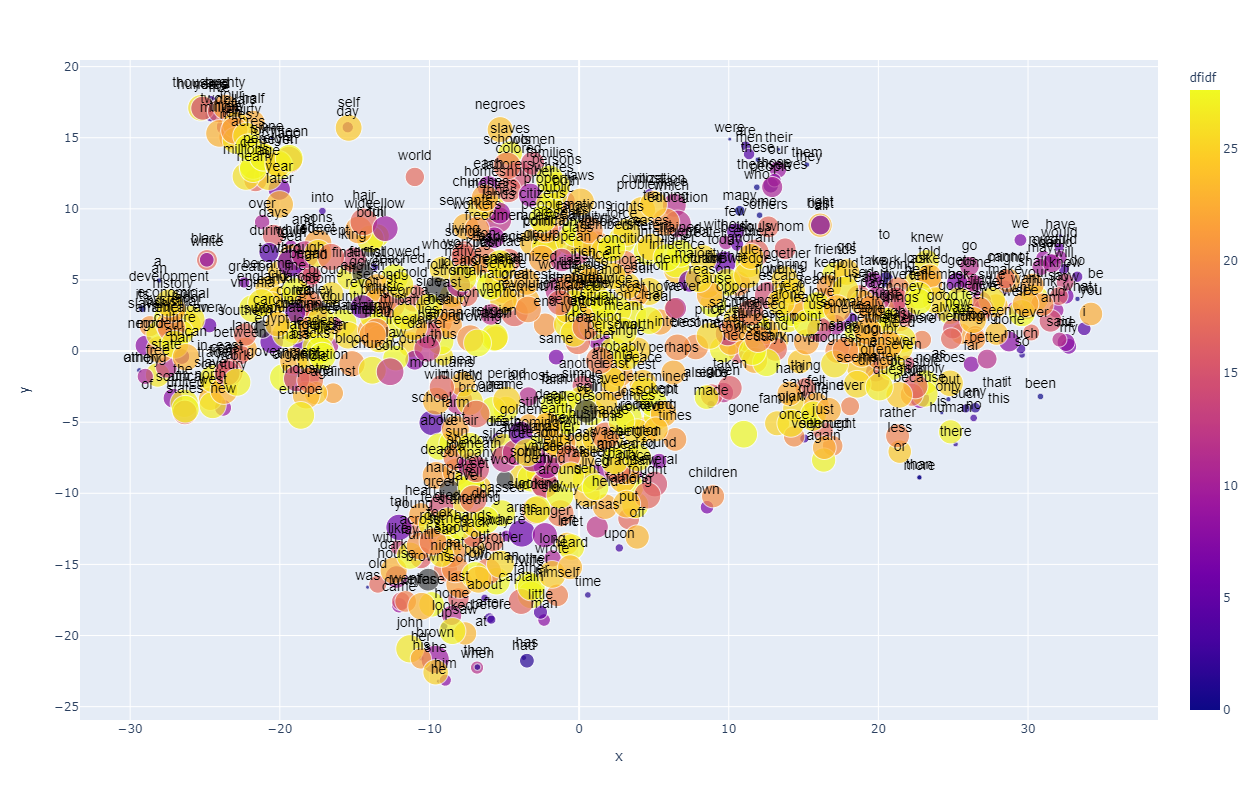

In [222]:
px.scatter(coords_bois.reset_index(), 'x', 'y', 
           text='term_str', 
           color='dfidf', 
           hover_name='term_str',          
           size='tfidf_max4_sum',
           height=800).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

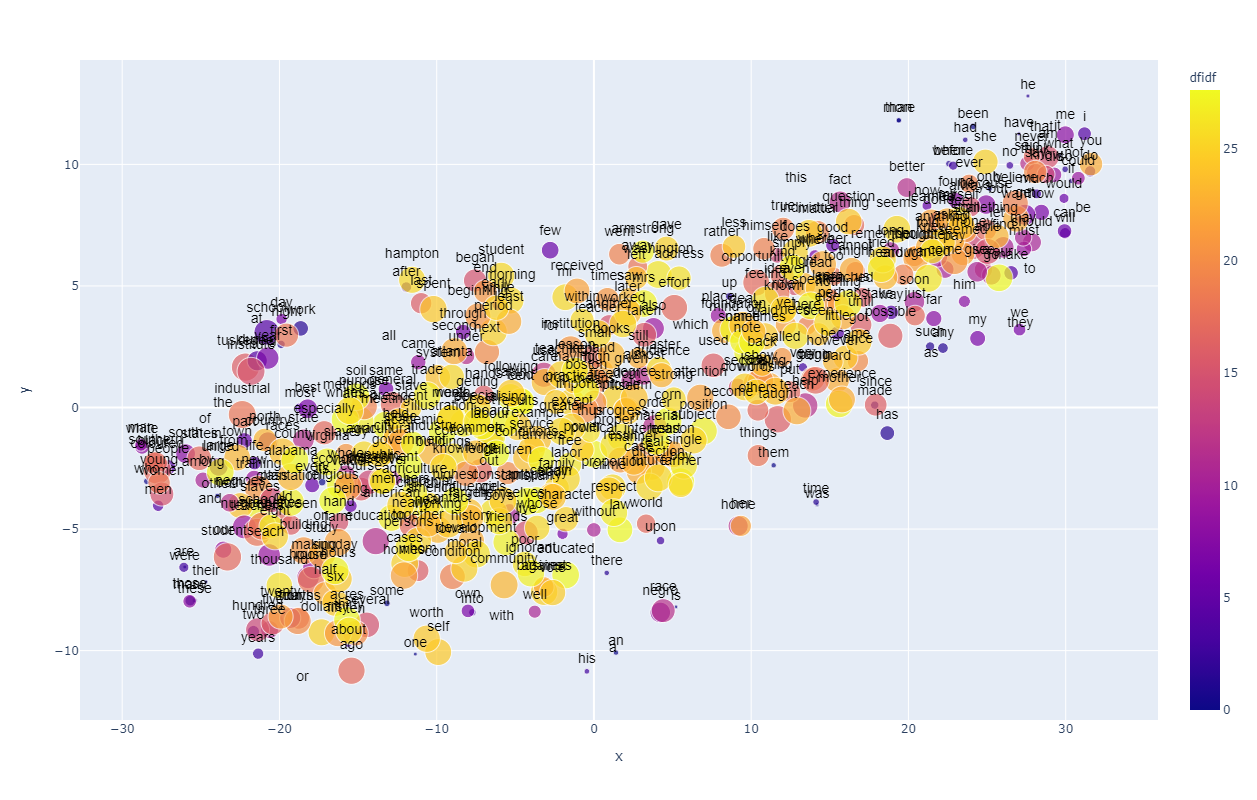

In [223]:
px.scatter(coords_booker.reset_index(), 'x', 'y', 
           text='term_str', 
           color='dfidf', 
           hover_name='term_str',          
           size='tfidf_max4_sum',
           height=800).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

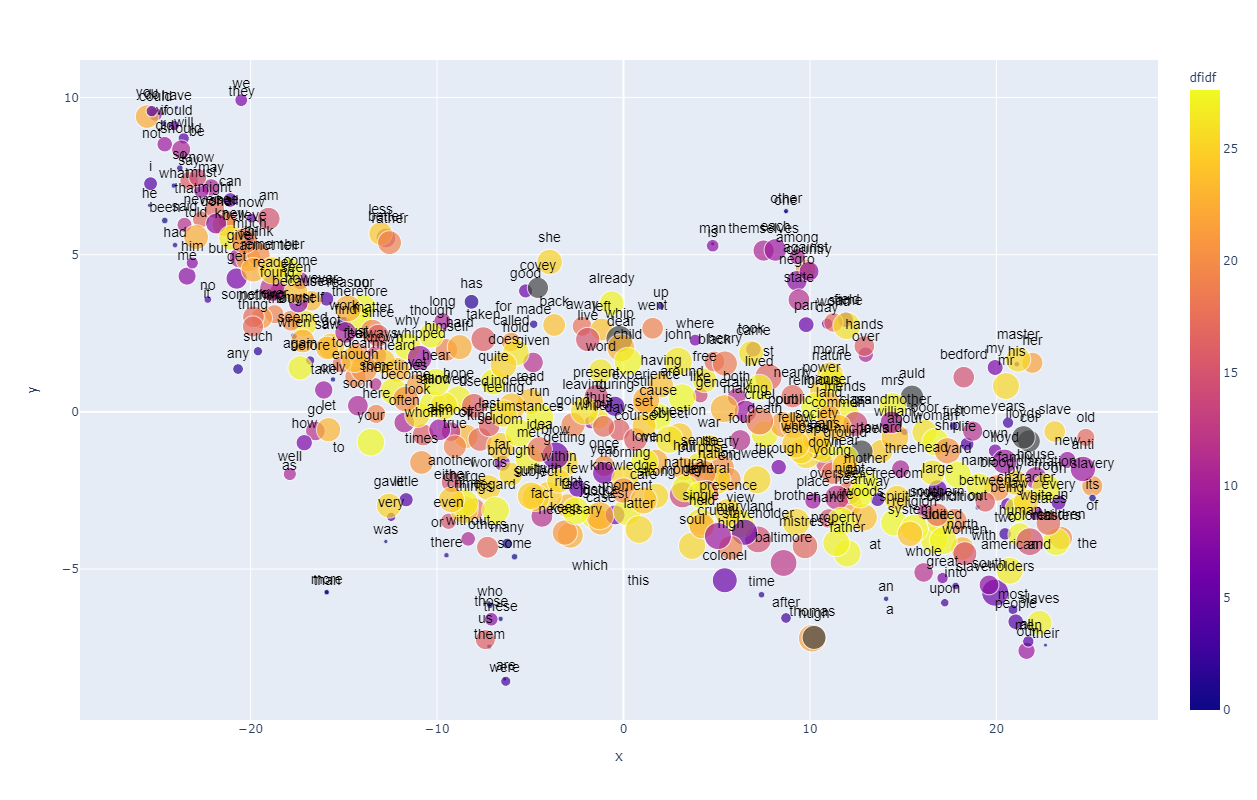

In [224]:
px.scatter(coords_fredrick.reset_index(), 'x', 'y', 
           text='term_str', 
           color='dfidf', 
           hover_name='term_str',          
           size='tfidf_max4_sum',
           height=800).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

In [195]:
def complete_analogy_f(A, B, C, n=2):
    try:
        cols = ['term', 'sim']
        return pd.DataFrame(model_fredrick.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
    except KeyError as e:
        print('Error:', e)
        return None
    
def get_most_similar(positive, negative=None):
    return pd.DataFrame(model_fredrick.wv.most_similar(positive, negative), columns=['term', 'sim'])

In [196]:
complete_analogy_f('slave', 'black', 'master', 3)

term       sim
0  thomas  0.941147
1   after  0.938573
2   covey  0.937902

In [190]:
def complete_analogy_b(A, B, C, n=2):
    try:
        cols = ['term', 'sim']
        return pd.DataFrame(model_bois.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
    except KeyError as e:
        print('Error:', e)
        return None
    
def get_most_similar(positive, negative=None):
    return pd.DataFrame(model_bois.wv.most_similar(positive, negative), columns=['term', 'sim'])

In [191]:
complete_analogy_b('slave', 'black', 'master', 3)

term       sim
0  together  0.879390
1      boys  0.874020
2     alone  0.865433

In [192]:
def complete_analogy_w(A, B, C, n=2):
    try:
        cols = ['term', 'sim']
        return pd.DataFrame(model_booker.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
    except KeyError as e:
        print('Error:', e)
        return None
    
def get_most_similar(positive, negative=None):
    return pd.DataFrame(model_booker.wv.most_similar(positive, negative), columns=['term', 'sim'])

In [193]:
complete_analogy_w('slave', 'black', 'master', 3)

term       sim
0     white  0.952731
1  southern  0.934256
2       man  0.922794

In [218]:
complete_analogy_b('black', 'brown', 'white', 3)

term       sim
0      she  0.787564
1   browns  0.781710
2  himself  0.760441

# Sentiment Analysis

In [245]:
emo_cols = "anger anticipation disgust fear joy sadness surprise trust polarity".split()

In [230]:
SALEX = pd.read_csv('{}/salex_nrc.csv'.format(data_in)).set_index('term_str')
SALEX.columns = [col.replace('nrc_','') for col in SALEX.columns]
SALEX['polarity'] = SALEX.positive - SALEX.negative

# pd.read_csv('{}/{}-DOC.csv'.format(data_out, data_prefix))

In [231]:
SALEX

anger  anticipation  disgust  fear  joy  negative  positive  \
term_str                                                                   
abandon          0             0        0     1    0         1         0   
abandoned        1             0        0     1    0         1         0   
abandonment      1             0        0     1    0         1         0   
abduction        0             0        0     1    0         1         0   
aberration       0             0        1     0    0         1         0   
...            ...           ...      ...   ...  ...       ...       ...   
young            0             1        0     0    1         0         1   
youth            1             1        0     1    1         0         1   
zeal             0             1        0     0    1         0         1   
zealous          0             0        0     0    1         0         1   
zest             0             1        0     0    1         0         1   

             sadness  surprise  trust  polarity  
term_str                                         
abandon            1         0      0        -1  
abandoned          1         0      0        -1  
abandonment        1         1      0        -1  
abduction          1         1      0        -1  
aberration         0         0      0        -1  
...              ...       ...    ...       ...  
young              0         1      0         1  
youth              0         1      0         1  
zeal               0         1      1         1  
zealous            0         0      1         1  
zest               0         0      1         1  

[3688 rows x 11 columns]

In [232]:
V = pd.concat([VOCAB.reset_index().set_index('term_str'), SALEX], join='inner', axis=1)\
    .reset_index().set_index('term_id')

In [237]:
bowIDX = bow.index
B = bow.merge(V, on='term_str', how='left').copy()
B.index = bowIDX
B = B.dropna()

In [ ]:
bcols = ['term_str', 'tf_n', 'tf_max4', 'tfidf__max4', 'df', 'idf', 'n', 'num', 'dfidf', 'p_stem', 
'tfidf_max4_sum', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust', 'polarity']

B = B[bcols]

for col in emo_cols:
    B[col] = B[col] * B.tfidf__max4

In [249]:
B

term_str  tf_n   tf_max4  tfidf__max4    df  \
book_id chap_num term_str                                                
23      1        absent      absent     1  0.406122     1.078802   5.0   
                 accurate  accurate     1  0.406122     1.866111   3.0   
                 argument  argument     1  0.406122     0.832805   7.0   
                 armed        armed     1  0.406122     0.885310   2.0   
                 awful        awful     1  0.406122     0.923124   3.0   
...                             ...   ...       ...          ...   ...   
64504   19       wealth      wealth     1  0.401935     0.562127  15.0   
                 white        white    19  0.436774     0.068810  46.0   
                 woefully  woefully     1  0.401935     2.483925   1.0   
                 word          word     1  0.401935     0.245202  25.0   
                 youth        youth     1  0.401935     0.746788  15.0   

                                idf       n  num      dfidf    p_stem  ...  \
book_id chap_num term_str                                              ...   
23      1        absent    3.378512    27.0  0.0  16.892558    absent  ...   
                 accurate  4.115477     6.0  0.0  12.346432     accur  ...   
                 argument  2.893085    64.0  0.0  20.251594  argument  ...   
                 armed     4.700440    64.0  0.0   9.400879       arm  ...   
                 awful     4.115477    64.0  0.0  12.346432        aw  ...   
...                             ...     ...  ...        ...       ...  ...   
64504   19       wealth    1.793549   115.0  0.0  26.903237    wealth  ...   
                 white     0.176878  1302.0  0.0   8.136377     white  ...   
                 woefully  5.700440     2.0  0.0   5.700440  woefulli  ...   
                 word      1.056584   204.0  0.0  26.414588      word  ...   
                 youth     1.793549    71.0  0.0  26.903237     youth  ...   

                           anticipation   disgust      fear       joy  \
book_id chap_num term_str                                               
23      1        absent        0.000000  0.000000  0.000000  0.000000   
                 accurate      0.000000  0.000000  0.000000  0.000000   
                 argument      0.000000  0.000000  0.000000  0.000000   
                 armed         0.000000  0.000000  0.885310  0.000000   
                 awful         0.000000  0.923124  0.923124  0.000000   
...                                 ...       ...       ...       ...   
64504   19       wealth        0.000000  0.000000  0.000000  0.562127   
                 white         0.068810  0.000000  0.000000  0.068810   
                 woefully      0.000000  2.483925  0.000000  0.000000   
                 word          0.000000  0.000000  0.000000  0.000000   
                 youth         0.746788  0.000000  0.746788  0.746788   

                           negative  positive   sadness  surprise     trust  \
book_id chap_num term_str                                                     
23      1        absent         1.0       0.0  1.078802  0.000000  0.000000   
                 accurate       0.0       1.0  0.000000  0.000000  1.866111   
                 argument       1.0       0.0  0.000000  0.000000  0.000000   
                 armed          1.0       1.0  0.000000  0.000000  0.000000   
                 awful          1.0       0.0  0.923124  0.000000  0.000000   
...                             ...       ...       ...       ...       ...   
64504   19       wealth         0.0       1.0  0.000000  0.000000  0.562127   
                 white          0.0       1.0  0.000000  0.000000  0.068810   
                 woefully       1.0       0.0  2.483925  0.000000  0.000000   
                 word           0.0       1.0  0.000000  0.000000  0.245202   
                 youth          0.0       1.0  0.000000  0.746788  0.000000   

                           polarity  
book_id chap_num term_str        

In [251]:
EMO_BOOKS = B.groupby(['book_id'])[emo_cols].mean()
EMO_CHAPS = B.groupby(['book_id','chap_num'])[emo_cols].mean()

In [253]:
EMO_BOOKS.index = LIB.title #book_title

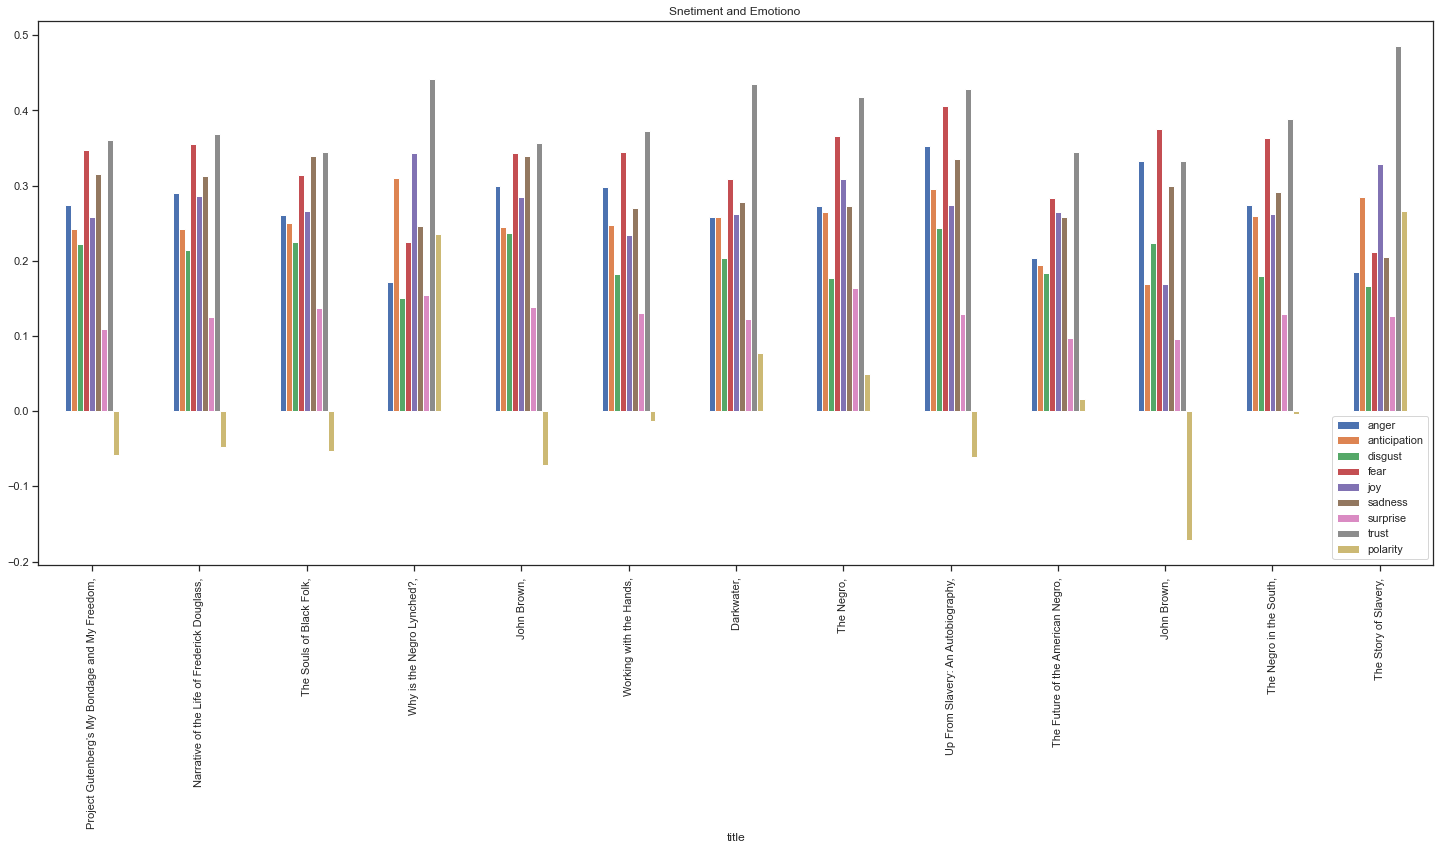

In [386]:
EMO_BOOKS.plot.bar(figsize=(25,10), title="Snetiment and Emotiono ")

In [255]:
EMO_CHAPS

anger  anticipation   disgust      fear       joy  \
book_id chap_num                                                         
23      1         0.310361      0.160564  0.236232  0.396504  0.176760   
        2         0.320331      0.207924  0.291089  0.326699  0.230701   
        3         0.246225      0.133174  0.160240  0.224573  0.235434   
        4         0.468678      0.228869  0.273921  0.549120  0.147209   
        5         0.163427      0.299056  0.198031  0.153681  0.550932   
...                    ...           ...       ...       ...       ...   
64504   15        0.287699      0.204240  0.238540  0.374267  0.283239   
        16        0.048109      0.312786  0.061301  0.195848  0.498194   
        17        0.144950      0.291160  0.156541  0.175721  0.274131   
        18        0.160931      0.274302  0.120484  0.167249  0.265609   
        19        0.267571      0.245715  0.190769  0.369690  0.285806   

                   sadness  surprise     trust  polarity  
book_id chap_num                                          
23      1         0.280514  0.103228  0.325407  0.002239  
        2         0.505557  0.064209  0.322277 -0.215272  
        3         0.301894  0.109959  0.371080 -0.010429  
        4         0.430822  0.115556  0.258930 -0.398465  
        5         0.206150  0.237209  0.403273  0.312331  
...                    ...       ...       ...       ...  
64504   15        0.228626  0.092847  0.395654  0.013688  
        16        0.090156  0.091778  0.690453  0.598899  
        17        0.170148  0.106383  0.573421  0.418434  
        18        0.171059  0.206962  0.446016  0.243624  
        19        0.293244  0.128431  0.438078 -0.042808  

[145 rows x 9 columns]

In [379]:
Fredrick_chaps_thin = EMO_CHAPS.stack().to_frame().reset_index().rename(columns={0:'value','level_2':'emo'}).query("book_id == {}".format(Author_bookid['Frederick Douglass'][:3]))
Bois_chaps_thin = EMO_CHAPS.stack().to_frame().reset_index().rename(columns={0:'value','level_2':'emo'}).query("book_id == {}".format([408,15210,15359,62799]))
Booker_chaps_thin = EMO_CHAPS.stack().to_frame().reset_index().rename(columns={0:'value','level_2':'emo'}).query("book_id == {}".format([2376,26507,64504]))

# Bois_chaps_thin= EMO_CHAPS.stack().to_frame().reset_index().rename(columns={0:'value','level_2':'emo'}).query("book_id == {}".format(mobydick))
# Booker_chaps_thin= EMO_CHAPS.stack().to_frame().reset_index().rename(columns={0:'value','level_2':'emo'}).query("book_id == {}".format(mobydick))

In [369]:
Fredrick202_chaps_thin

book_id  chap_num           emo     value
0          23         1         anger  0.310361
1          23         1  anticipation  0.160564
2          23         1       disgust  0.236232
3          23         1          fear  0.396504
4          23         1           joy  0.176760
...       ...       ...           ...       ...
1012    59116         7           joy  0.208480
1013    59116         7       sadness  0.217421
1014    59116         7      surprise  0.039330
1015    59116         7         trust  0.431413
1016    59116         7      polarity  0.102590

[396 rows x 4 columns]

In [343]:
def plot_sentiments(df, emo='polarity'):
    FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)
    df[emo].plot(**FIG)
    
    

In [353]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=3, cols=1)

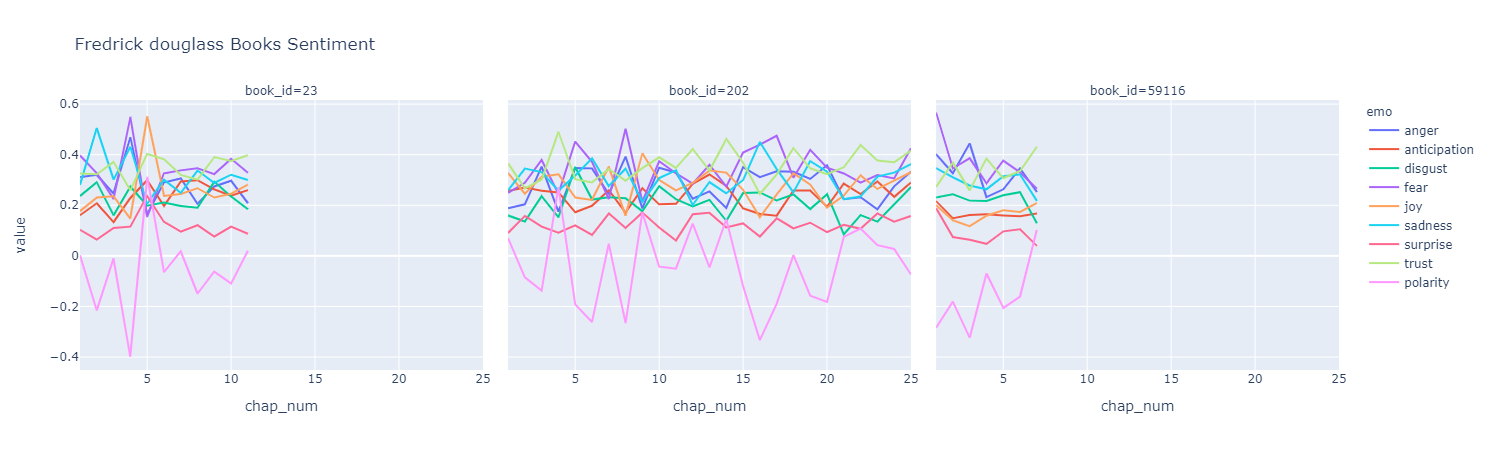

In [391]:
px.line(Fredrick_chaps_thin, x='chap_num', y='value', color='emo', facet_col='book_id', title="Fredrick douglass Books Sentiment")

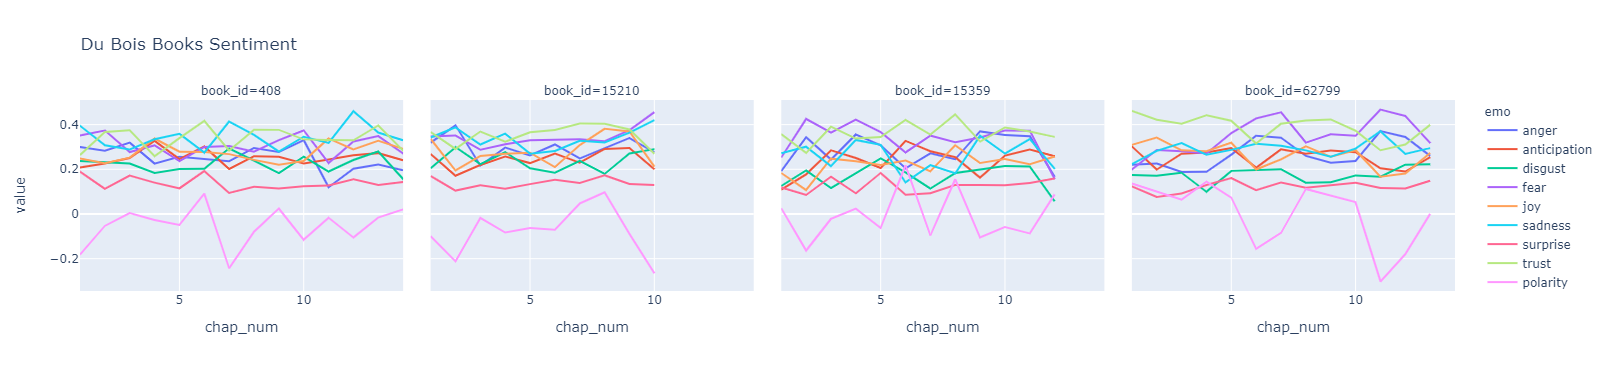

In [392]:
px.line(Bois_chaps_thin, x='chap_num', y='value', color='emo', facet_col='book_id', title="Du Bois Books Sentiment")

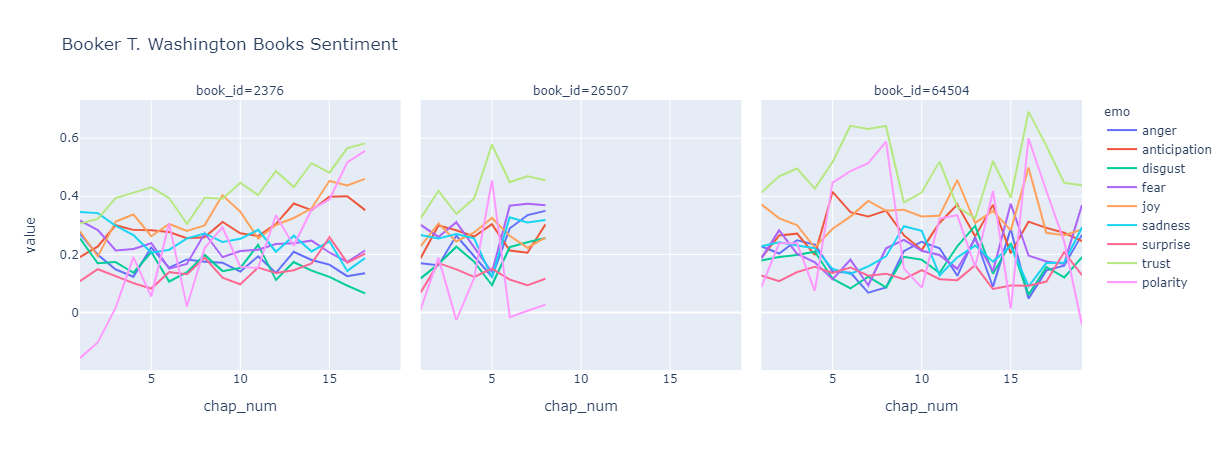

In [382]:
px.line(Booker_chaps_thin, x='chap_num', y='value', color='emo', facet_col='book_id', title="Booker T. Washington Books Sentiment")

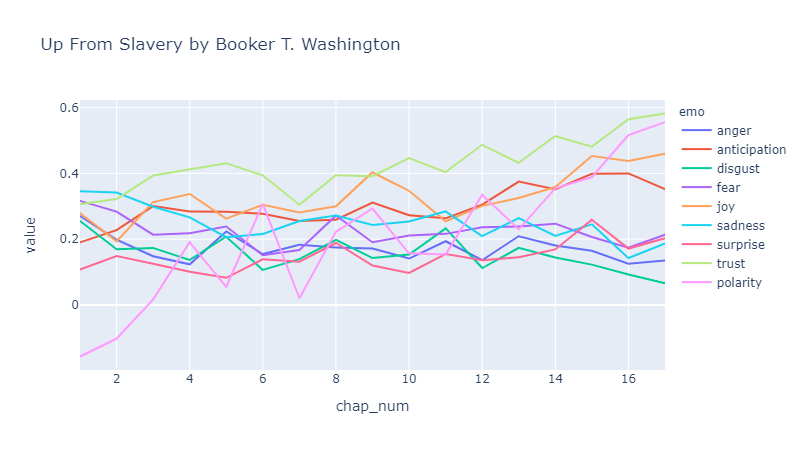

In [394]:
px.line(EMO_CHAPS.stack().to_frame().reset_index().rename(columns={0:'value','level_2':'emo'}).query("book_id == {}".format([2376])), x='chap_num', y='value', color='emo', title="Up From Slavery by Booker T. Washington")

In [387]:
LIB

book_title  \
book_id                                                      
202      Project Gutenberg’s My Bondage and My Freedom,...   
23       Narrative of the Life of Frederick Douglass, b...   
408           The Souls of Black Folk, by W. E. B. Du Bois   
59116     Why is the Negro Lynched?, by Frederick Douglass   
62799               John Brown, by W. E. Burghardt Du Bois   
64504                 Working with the Hands, by Booker T.   
15210                       Darkwater, by W. E. B. Du Bois   
15359                         The Negro, by W.E.B. Du Bois   
2376     Up From Slavery: An Autobiography, by Booker T...   
26507    The Future of the American Negro, by Booker T....   
31839                    John Brown, by Frederick Douglass   
35399    The Negro in the South, by Booker T. Washingto...   
45125        The Story of Slavery, by Booker T. Washington   

                     book_file  \
book_id                          
202        ./data_in\202-0.txt   
23          ./data_in\23-0.txt   
408        ./data_in\408-0.txt   
59116    ./data_in\59116-0.txt   
62799    ./data_in\62799-0.txt   
64504    ./data_in\64504-0.txt   
15210    ./data_in\pg15210.txt   
15359    ./data_in\pg15359.txt   
2376      ./data_in\pg2376.txt   
26507    ./data_in\pg26507.txt   
31839    ./data_in\pg31839.txt   
35399    ./data_in\pg35399.txt   
45125    ./data_in\pg45125.txt   

                                                   title  \
book_id                                                    
202      Project Gutenberg’s My Bondage and My Freedom,    
23         Narrative of the Life of Frederick Douglass,    
408                            The Souls of Black Folk,    
59116                        Why is the Negro Lynched?,    
62799                                       John Brown,    
64504                           Working with the Hands,    
15210                                        Darkwater,    
15359                                        The Negro,    
2376                 Up From Slavery: An Autobiography,    
26507                 The Future of the American Negro,    
31839                                       John Brown,    
35399                           The Negro in the South,    
45125                             The Story of Slavery,    

                                                   Author genre  
book_id                                                          
202                                    Frederick Douglass     b  
23                                     Frederick Douglass     b  
408                                      W. E. B. Du Bois     n  
59116                                  Frederick Douglass     n  
62799                                    W. E. B. Du Bois     b  
64504                                Booker T. Washington     n  
15210                                    W. E. B. Du Bois     n  
15359                                    W. E. B. Du Bois     n  
2376                                 Booker T. Washington     b  
26507                                Booker T. Washington     n  
31839                                  Frederick Douglass     b  
35399     Booker T. Washington and W. E. Burghardt DuBois     n  
45125                                Booker T. Washington     n